In [1]:
import numpy as np
import os
import itertools
import functools
import scienceplots
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
plt.style.use(['science', 'ieee'])

In [4]:
%ls

'Analyze traces.ipynb'            perf-upload-wq.out.svg
 archives/                        results.zip
 baseline/                        res-wq/
 download-res/                    sandbox/
 FlameGraph/                      sar/
 helpers.sh                       segments.csv
 helpers-trace-cmd.sh             trace-download.dat
 master.zip                       traces/
 perf/                            trace-upload.dat
 perf-download.out.svg            up-down/
 perf-download-threaded.out       up-down-2/
 perf-download-threaded.out.svg   up-down-2.zip
 perf-download-wq.out             up-down-3/
 perf-download-wq.out.svg         up-down-base/
 perf-upload.out.svg              up-down-threaded/
 perf-upload-threaded.out         up-down-wq/
 perf-upload-threaded.out.svg     up-down.zip
 perf-upload-wq.out               upload-res/


In [5]:
funcgraph_names = ['type', 'thread_name', 'core', 'timestamp', 'function', 'start', 'end']
rx_stop_names = ['type', "timestamp", 'core', 'stop']
stop_types = {
    1: "LIST_EMPTY",
    2: "CRYPTED_PACKET"
}
worker_names = ['type', 'thread_name', 'core', 'duration', 'work']
packet_names = ['type', 'thread_name', 'core', 'timestamp', 'duration']
segs_names = ['type', 'timestamp', 'segments']

In [6]:
def funcgraph_post_processing(upload):
    upload['start'] = upload['start'].apply(lambda x: int(x, 16))
    upload['end'] = upload['end'].apply(lambda x: int(x, 16))
    upload['duration'] = upload.end - upload.start
    starttime = upload.timestamp.iloc[0]
    upload.timestamp = upload.timestamp.apply(lambda x: (x - starttime) * 1e9)
    starttime = upload.start.iloc[0]
    upload.start = upload.start.apply(lambda x: (x - starttime))
    starttime = upload.end.iloc[0]
    upload.end = upload.end.apply(lambda x: (x - starttime))  
    return upload

def tx_stop_post_processing(df):
    df['stop'] = df.stop.apply(lambda x: 2 if x == '2' else 1)
    return df

def rx_stop_post_processing(df):
#     df['stop'] = df.stop.apply(lambda x: 1 if x == '1' else 2)
    return df
    
def read_csv(path, names, kind='funcgraph'):
    upload = pd.read_csv(path, names=names)
    if kind == 'funcgraph':
        upload = funcgraph_post_processing(upload)
    if kind == 'rx_stop':
        upload = rx_stop_post_processing(upload)
    if kind == 'tx_stop':
        upload = tx_stop_post_processing(upload)
    return upload

In [17]:
variant = "res-wq"

In [18]:
seg_df = read_csv("segments.csv", names=segs_names, kind='segs')

In [19]:
seg_df['segmented'] = seg_df.segments.apply(lambda row: "SEGMENTED" if row > 1 else "NOT_SEGMENTED" )

In [20]:
up_funcgraph = read_csv(f"{variant}/trace-upload.dat.funcgraph.csv", names=funcgraph_names, kind='funcgraph')
down_funcgraph = read_csv(f"{variant}/trace-download.dat.funcgraph.csv", names=funcgraph_names, kind='funcgraph')

In [21]:
prefix = "upload-res/trace-upload.dat"

In [22]:
up_rx_stop = read_csv(f"{variant}/trace-upload.dat.rx-stop.csv", names=rx_stop_names, kind='rx_stop')
down_tx_stop = read_csv(f"{variant}/trace-download.dat.tx-stop.csv", names=rx_stop_names, kind='tx_stop')

In [23]:
up_rx_worker = read_csv(f"{variant}/trace-upload.dat.RX-worker.csv", names=worker_names, kind='worker')
down_tx_worker = read_csv(f"{variant}/trace-download.dat.TX-worker.csv", names=worker_names, kind='worker')

In [24]:
up_rx_packet = read_csv(f"{variant}/trace-upload.dat.RX-packet.csv", names=packet_names, kind='packet')
down_tx_packet = read_csv(f"{variant}/trace-download.dat.TX-packet.csv", names=packet_names, kind='packet')

In [25]:
up_decrypt_packet = read_csv(f"{variant}/trace-upload.dat.DECRYPT-packet.csv", names=packet_names, kind='packet')
down_encrypt_packet = read_csv(f"{variant}/trace-download.dat.ENCRYPT-packet.csv", names=packet_names, kind='packet')

In [26]:
up_funcgraph.head()

,type,thread_name,core,timestamp,function,start,end,duration
0,NaN,kworker/16:28-223400,16,0.000000,wg_packet_rx_poll,0,0,4718
1,NaN,kworker/10:16-223169,10,3000.001016,wg_packet_rx_poll,1184,3055,6589
2,NaN,kworker/16:28-223400,16,5999.998393,wg_packet_rx_poll,5904,5870,4684
3,NaN,kworker/10:16-223169,10,8999.999409,wg_packet_rx_poll,8859,9154,5013
4,NaN,kworker/9:12-216072,9,11000.000086,wg_packet_tx_worker,11942,11242,4018


In [27]:
colors = ['red', 'blue', 'orange', 'green']
functions = ['wg_packet_encrypt_worker', 'wg_packet_decrypt_worker', 'wg_packet_tx_worker', 'wg_packet_rx_poll']
colormap = {f: c for f,c in zip(functions, colors)}

In [28]:
def plot_funcgraph(upload, starttime, interval_range, funcs=functions):
    df = upload[(upload.start.between(starttime, starttime + interval_range)) | (upload.end.between(starttime, starttime + interval_range))].reset_index(drop=True)
    df = df[df.function.isin(funcs)]

    with plt.style.context(['science', 'ieee']):
        plt.rcParams.update({'font.size': 16})
        plt.figure(figsize=(15, 4))

        for i, row in df.iterrows():
            plt.hlines(y=row.core, xmin=row.start, xmax=row.end, color=colormap[row.function], linewidth=3)

        legend = plt.legend(functions, bbox_to_anchor=(1.1, 1.2), ncol=4)
        plt.xlim([starttime, starttime + interval_range])

        for i, color in enumerate(colors):
            legend.get_lines()[i].set_color(color)

In [29]:
starttime = 3e9
interval_range = 1e7
funcs = ['wg_packet_rx_poll', 'wg_packet_decrypt_worker']
funcs = functions

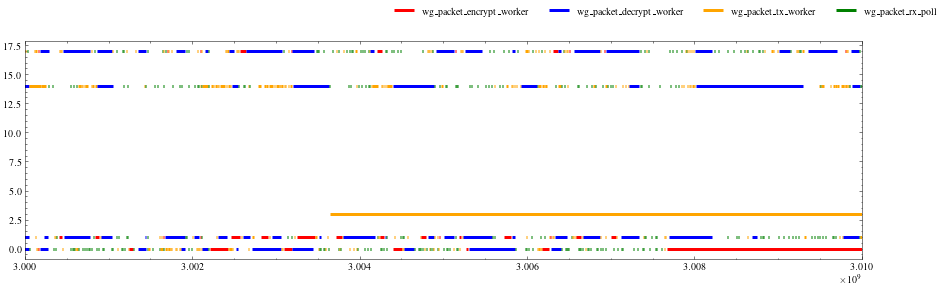

In [30]:
plot_funcgraph(up_funcgraph, starttime, interval_range, funcs=funcs)

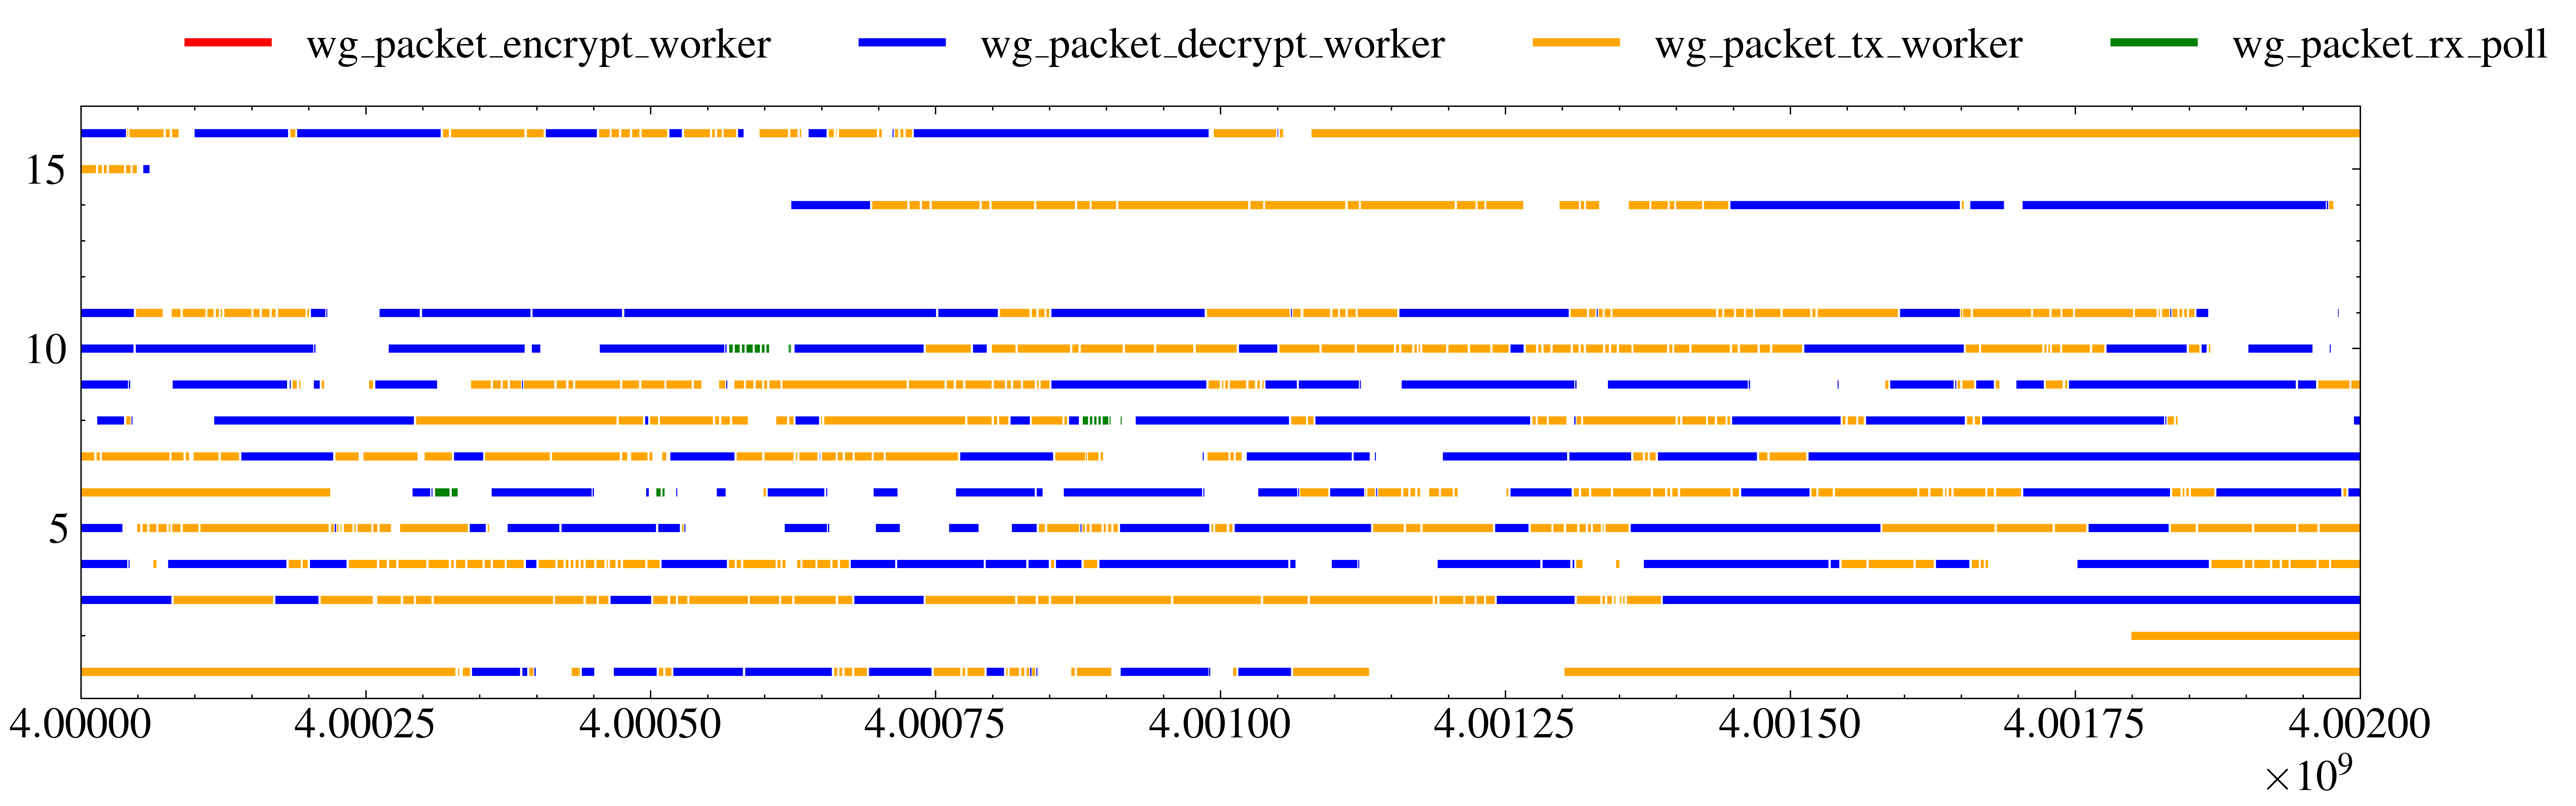

In [248]:
plot_funcgraph(down_funcgraph, starttime, interval_range, funcs=funcs)

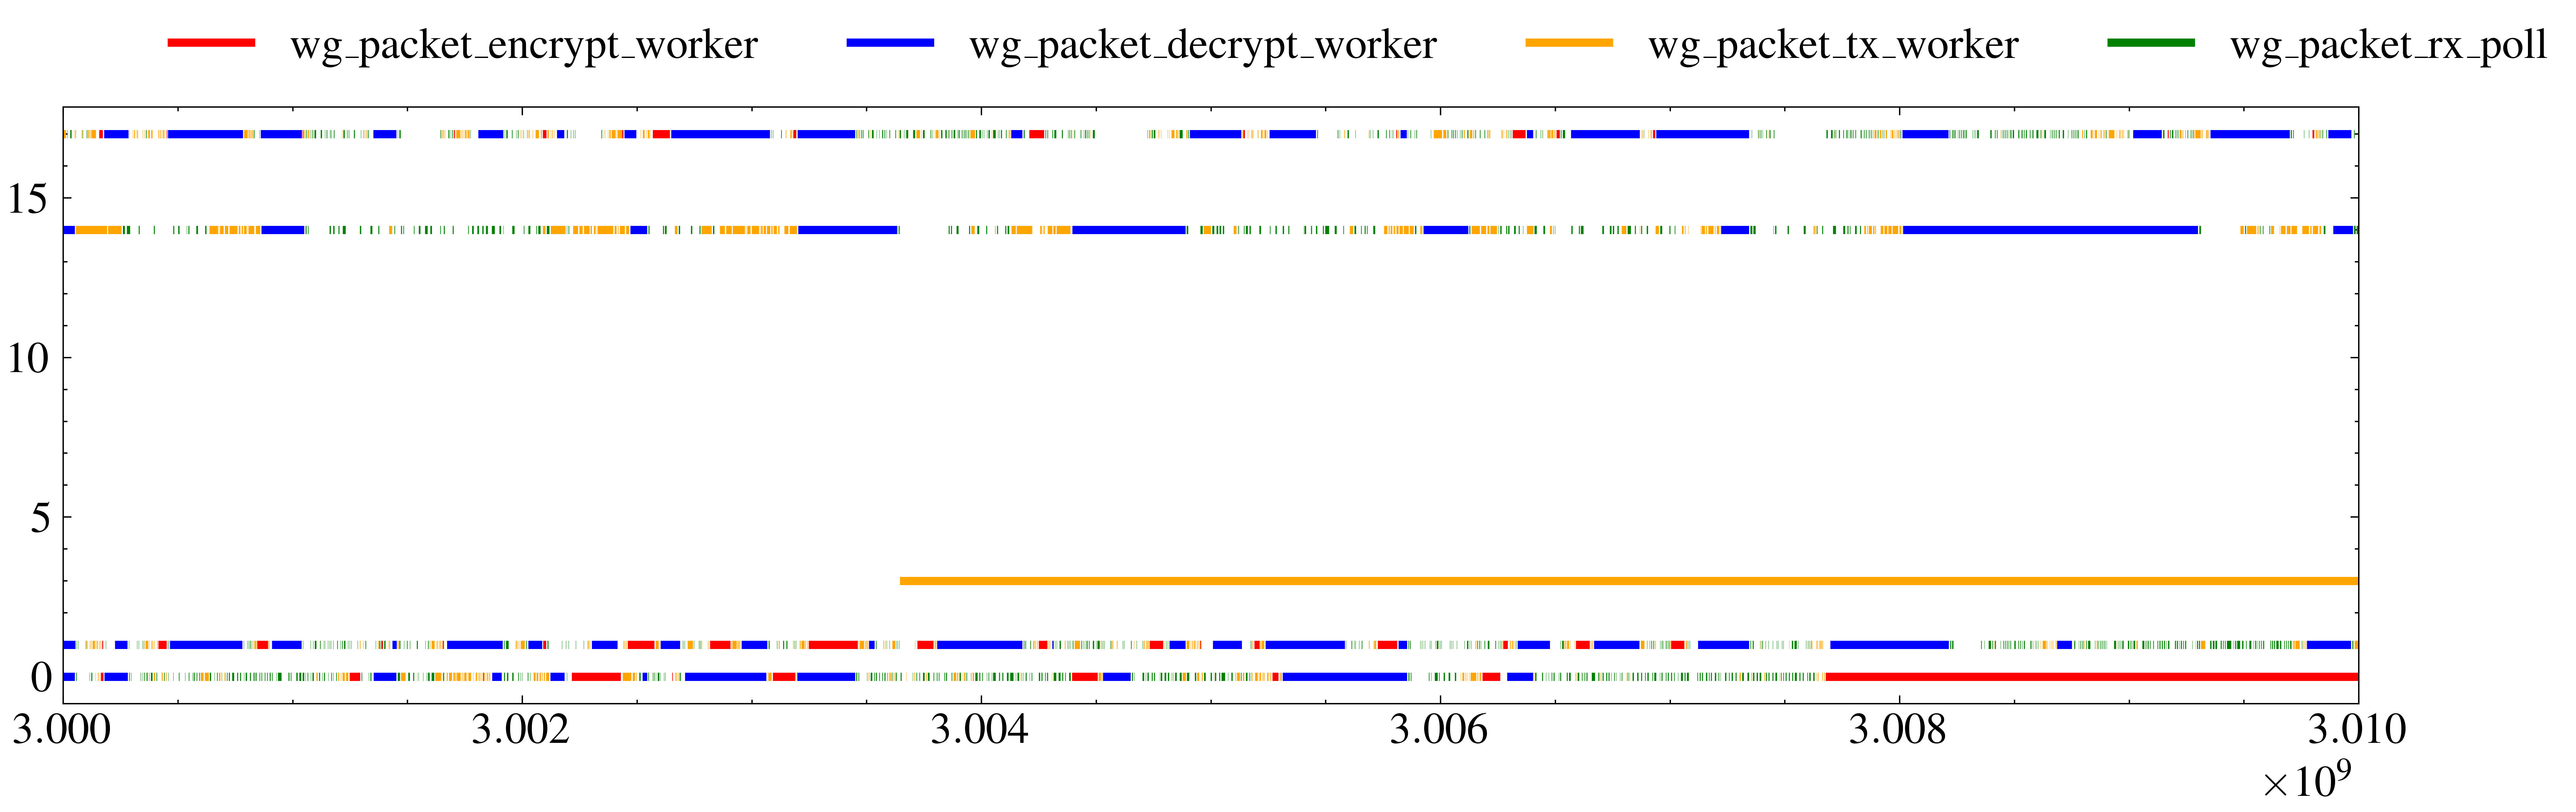

In [263]:
plot_funcgraph(up_funcgraph, starttime, interval_range, funcs=funcs)

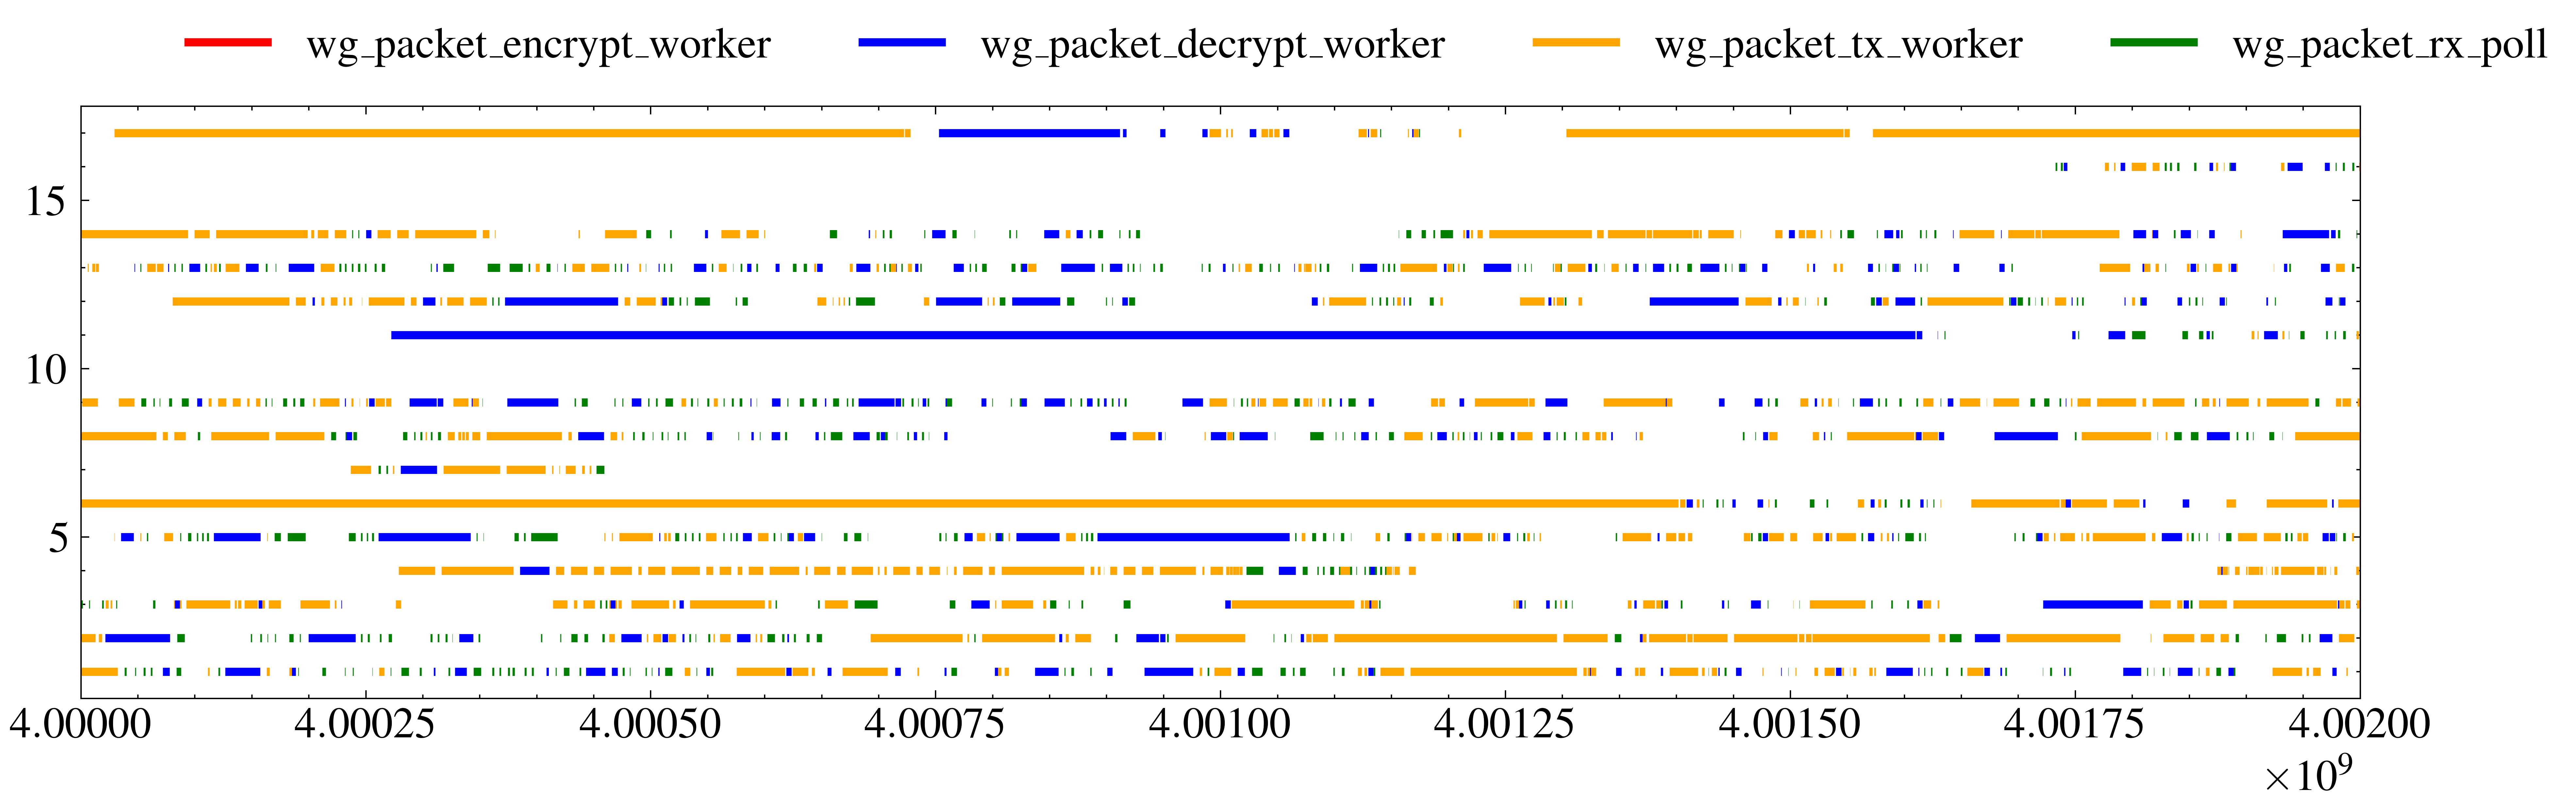

In [259]:
plot_funcgraph(down_funcgraph, starttime, interval_range, funcs=funcs)

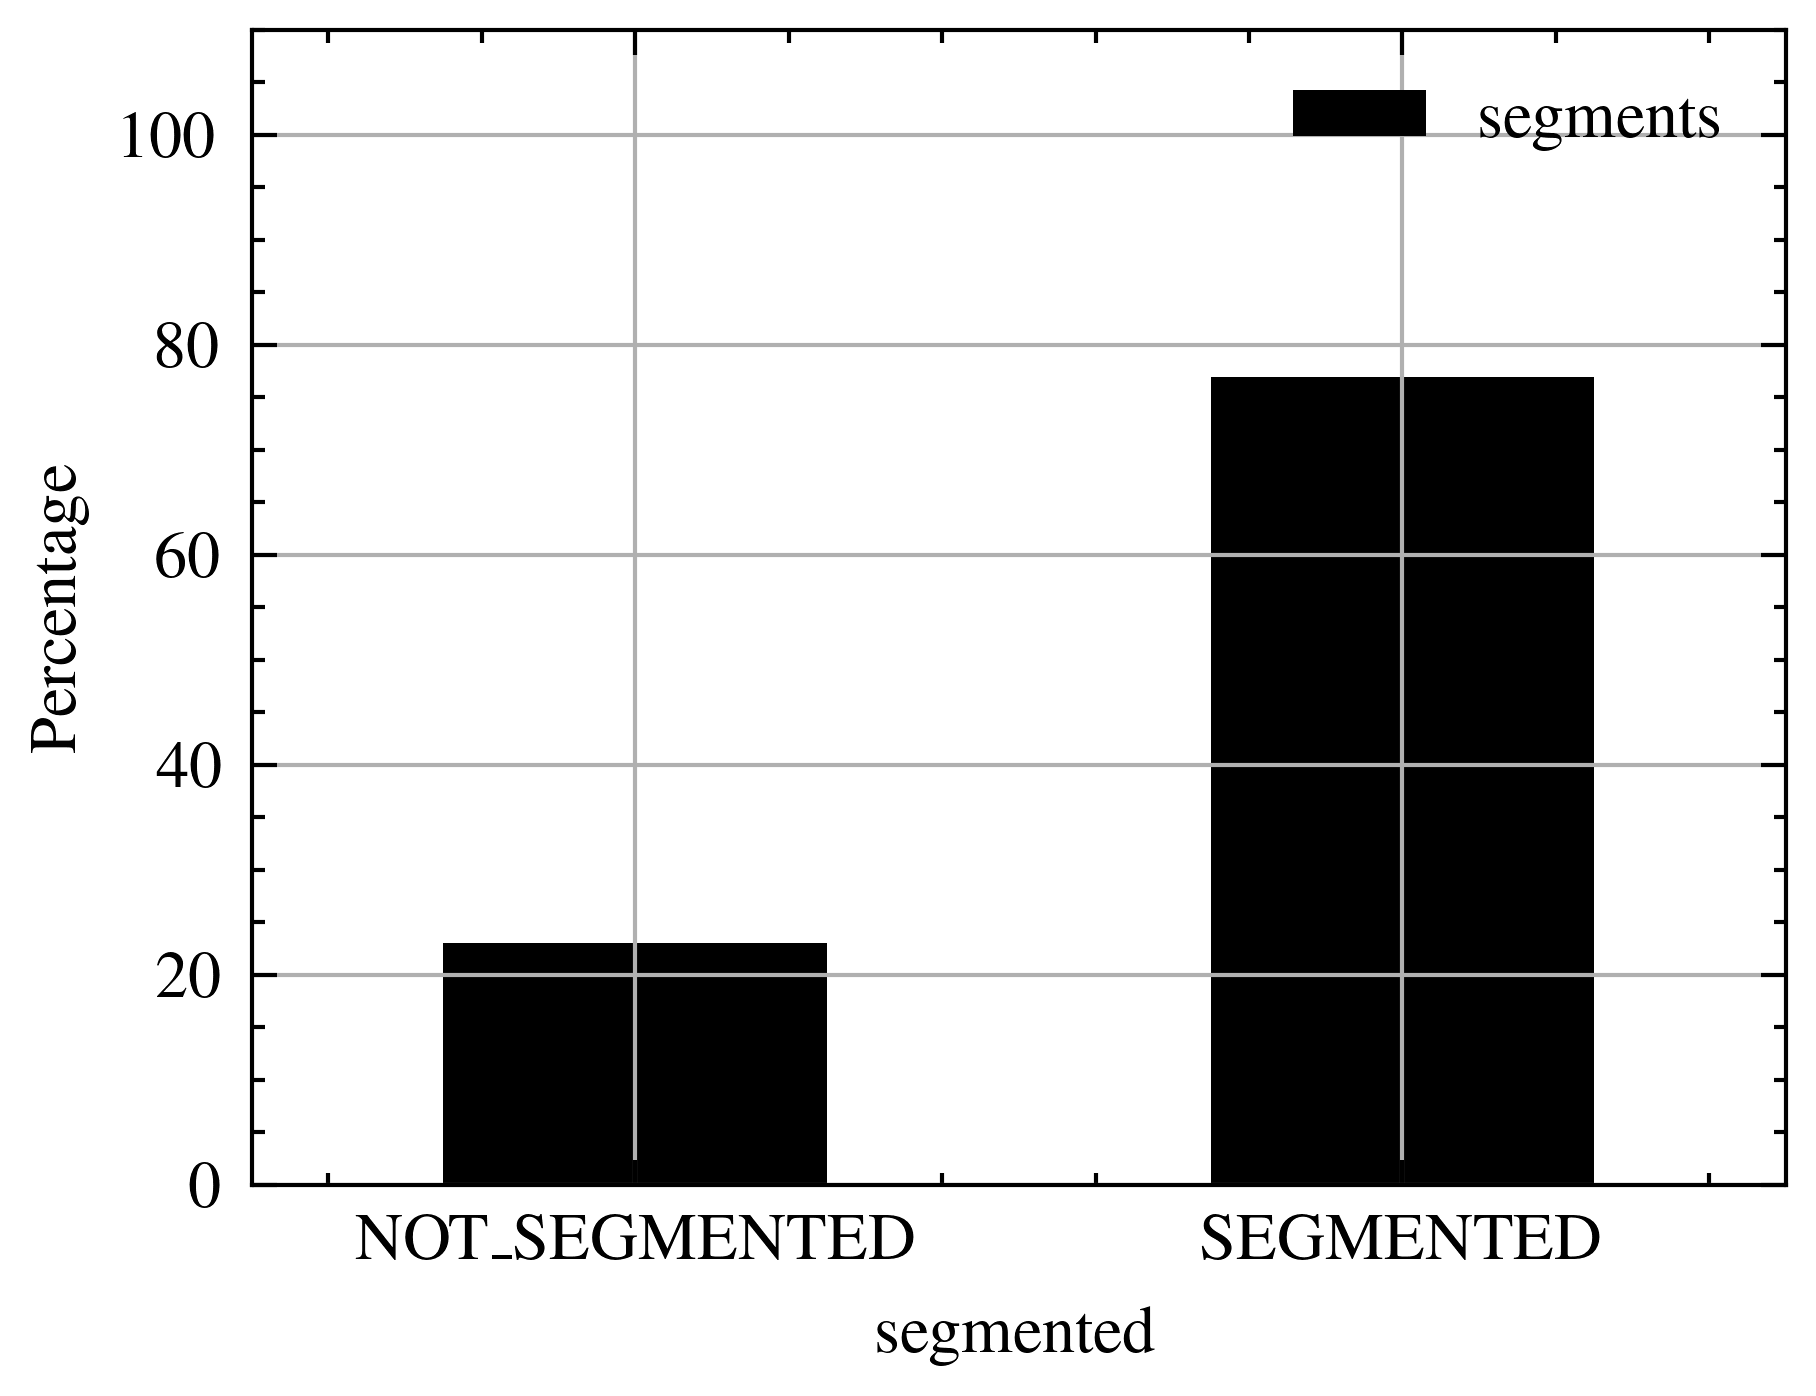

,segmented,type,timestamp,segments
0,NOT_SEGMENTED,0.0,23.062026,23.062026
1,SEGMENTED,0.0,76.937974,76.937974


In [31]:
count = seg_df.groupby('segmented').count()
total = seg_df.count().segments
count = count * 100 / total
count = count.reset_index()
# count['Chunks'] = count.apply(lambda row: stop_types[row.segments], axis=1)
count.plot.bar(x='segmented', y='segments', ylabel='Percentage', ylim=[0, 110], grid=True)
plt.xticks(rotation=0)
plt.show()
count

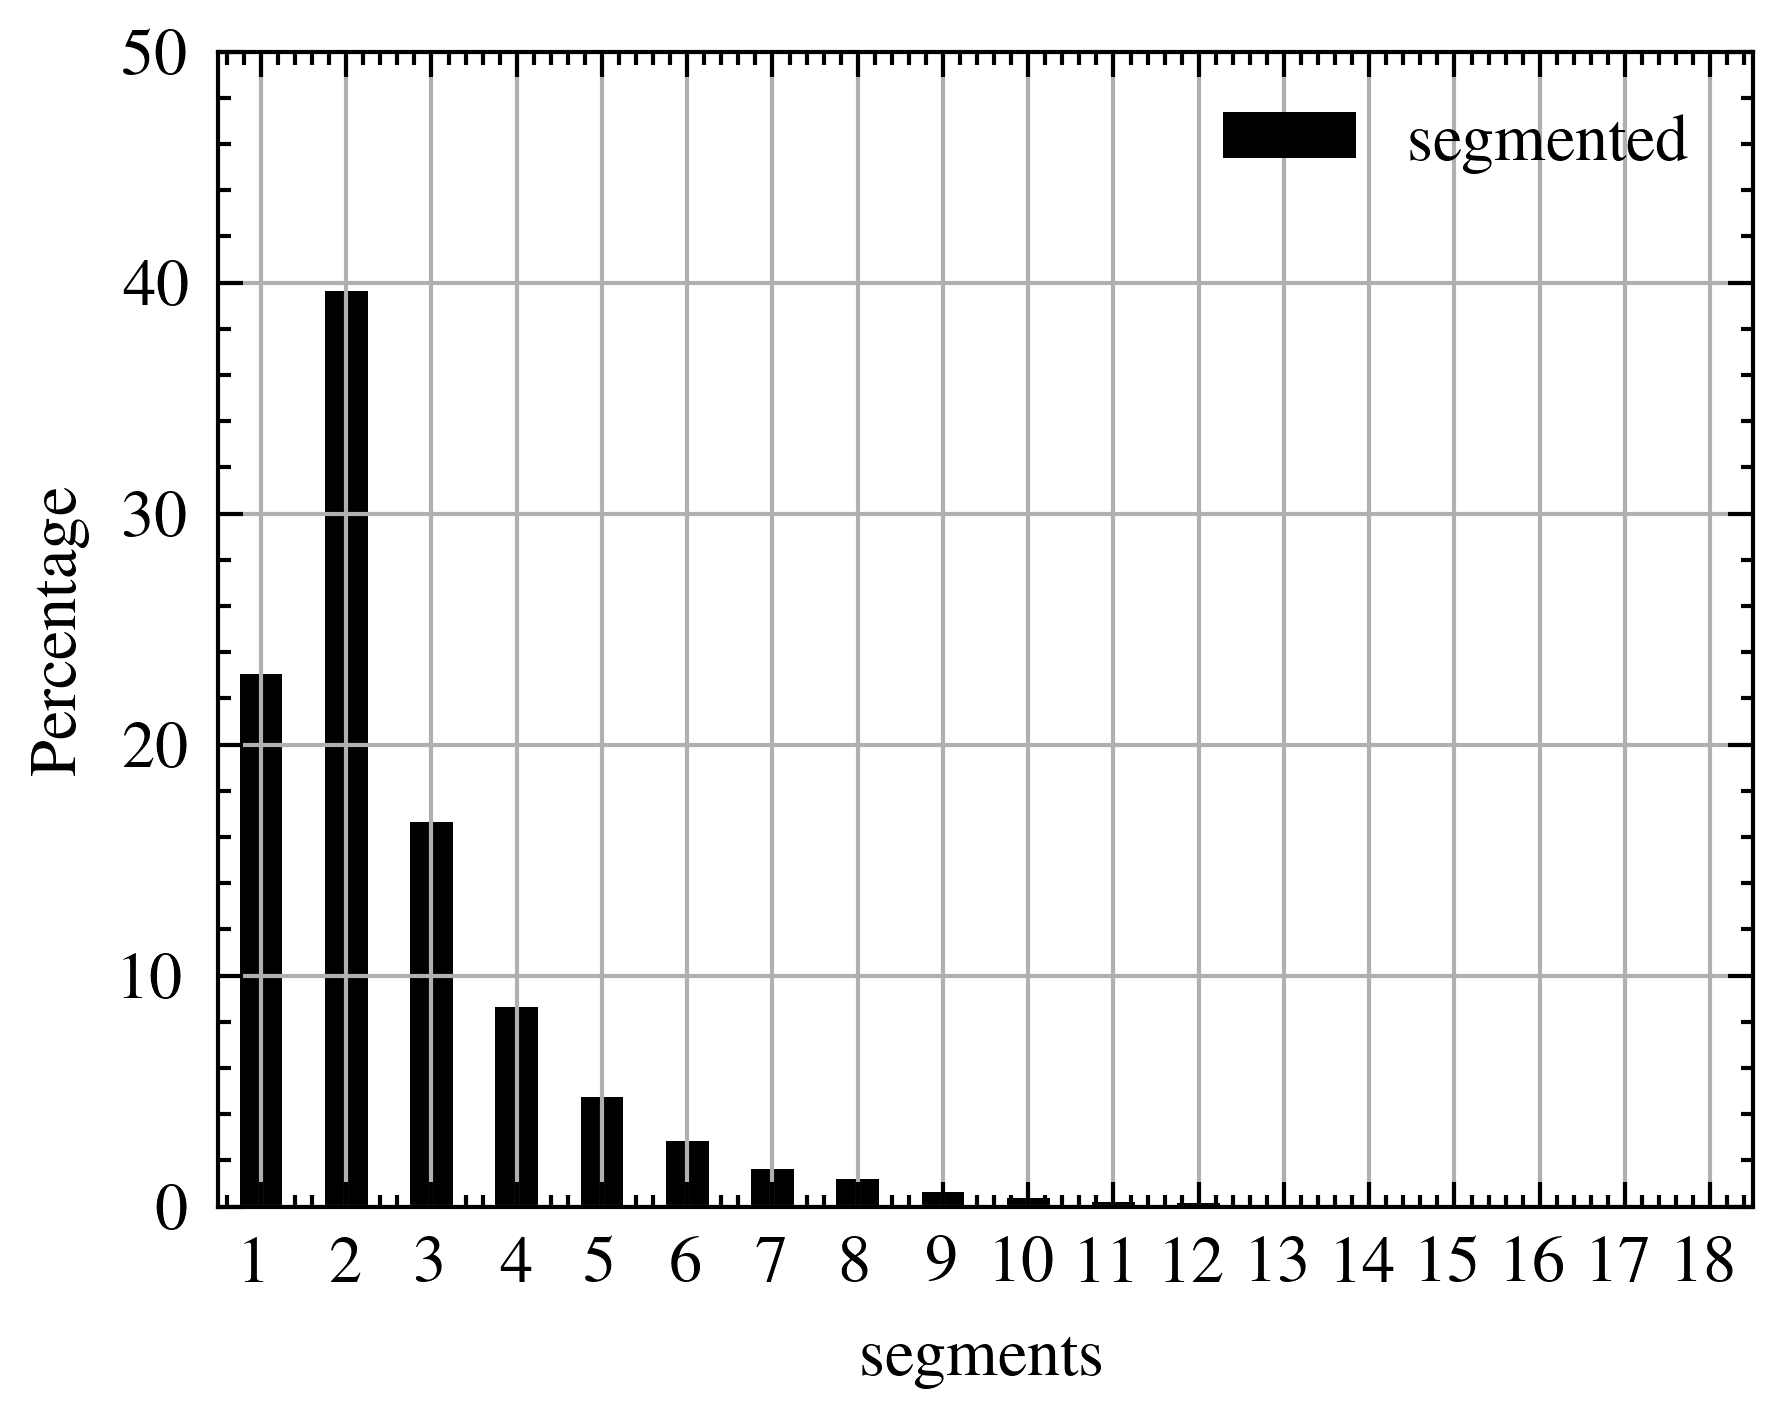

In [32]:
with plt.style.context(['science', 'ieee']):
    count = seg_df.groupby('segments').count()
    total = seg_df.count().segmented
    count = count * 100 / total
    count = count.reset_index()
    # count['Chunks'] = count.apply(lambda row: stop_types[row.segments], axis=1)
    count.plot.bar(x='segments', y='segmented', ylabel='Percentage', ylim=[0, 50], grid=True)
    plt.xticks(rotation=0)
    plt.show()
    count

In [42]:
plt.rcParams.update({'font.size': 11.5})

In [56]:
path = "resdir"

In [59]:
variant = "base"

In [66]:
def plot_stops_up_down(variant="base"):
    up_stop = read_csv(f"{path}/trace-upload-{variant}.dat.POLL_STOP.csv", names=rx_stop_names, kind='rx_stop')
    down_stop = read_csv(f"{path}/trace-download-{variant}.dat.POLL_STOP.csv", names=rx_stop_names, kind='rx_stop')
    
    count = up_stop.groupby('stop').count()
    total = up_stop.count().stop
    count = count * 100 / total
    count = count.reset_index()
    count['RX STOP'] = count.apply(lambda row: stop_types[row.stop], axis=1)
    count.plot.bar(
        x='RX STOP', y='core', ylim=[0, 110], grid=True, 
        xlabel="GRO Stopping Reasons", ylabel='Percentage'
    )
    plt.xticks(rotation=0)
    plt.show()
    print(count)
    
    count = down_stop.groupby('stop').count()
    total = down_stop.count().stop
    count = count * 100 / total
    count = count.reset_index()
    count['RX STOP'] = count.apply(lambda row: stop_types[row.stop], axis=1)
    count.plot.bar(
        x='RX STOP', y='core', ylim=[0, 110], grid=True, 
        xlabel="GRO Stopping Reasons", ylabel='Percentage'
    )
    plt.xticks(rotation=0)
    plt.show()
    print(count)

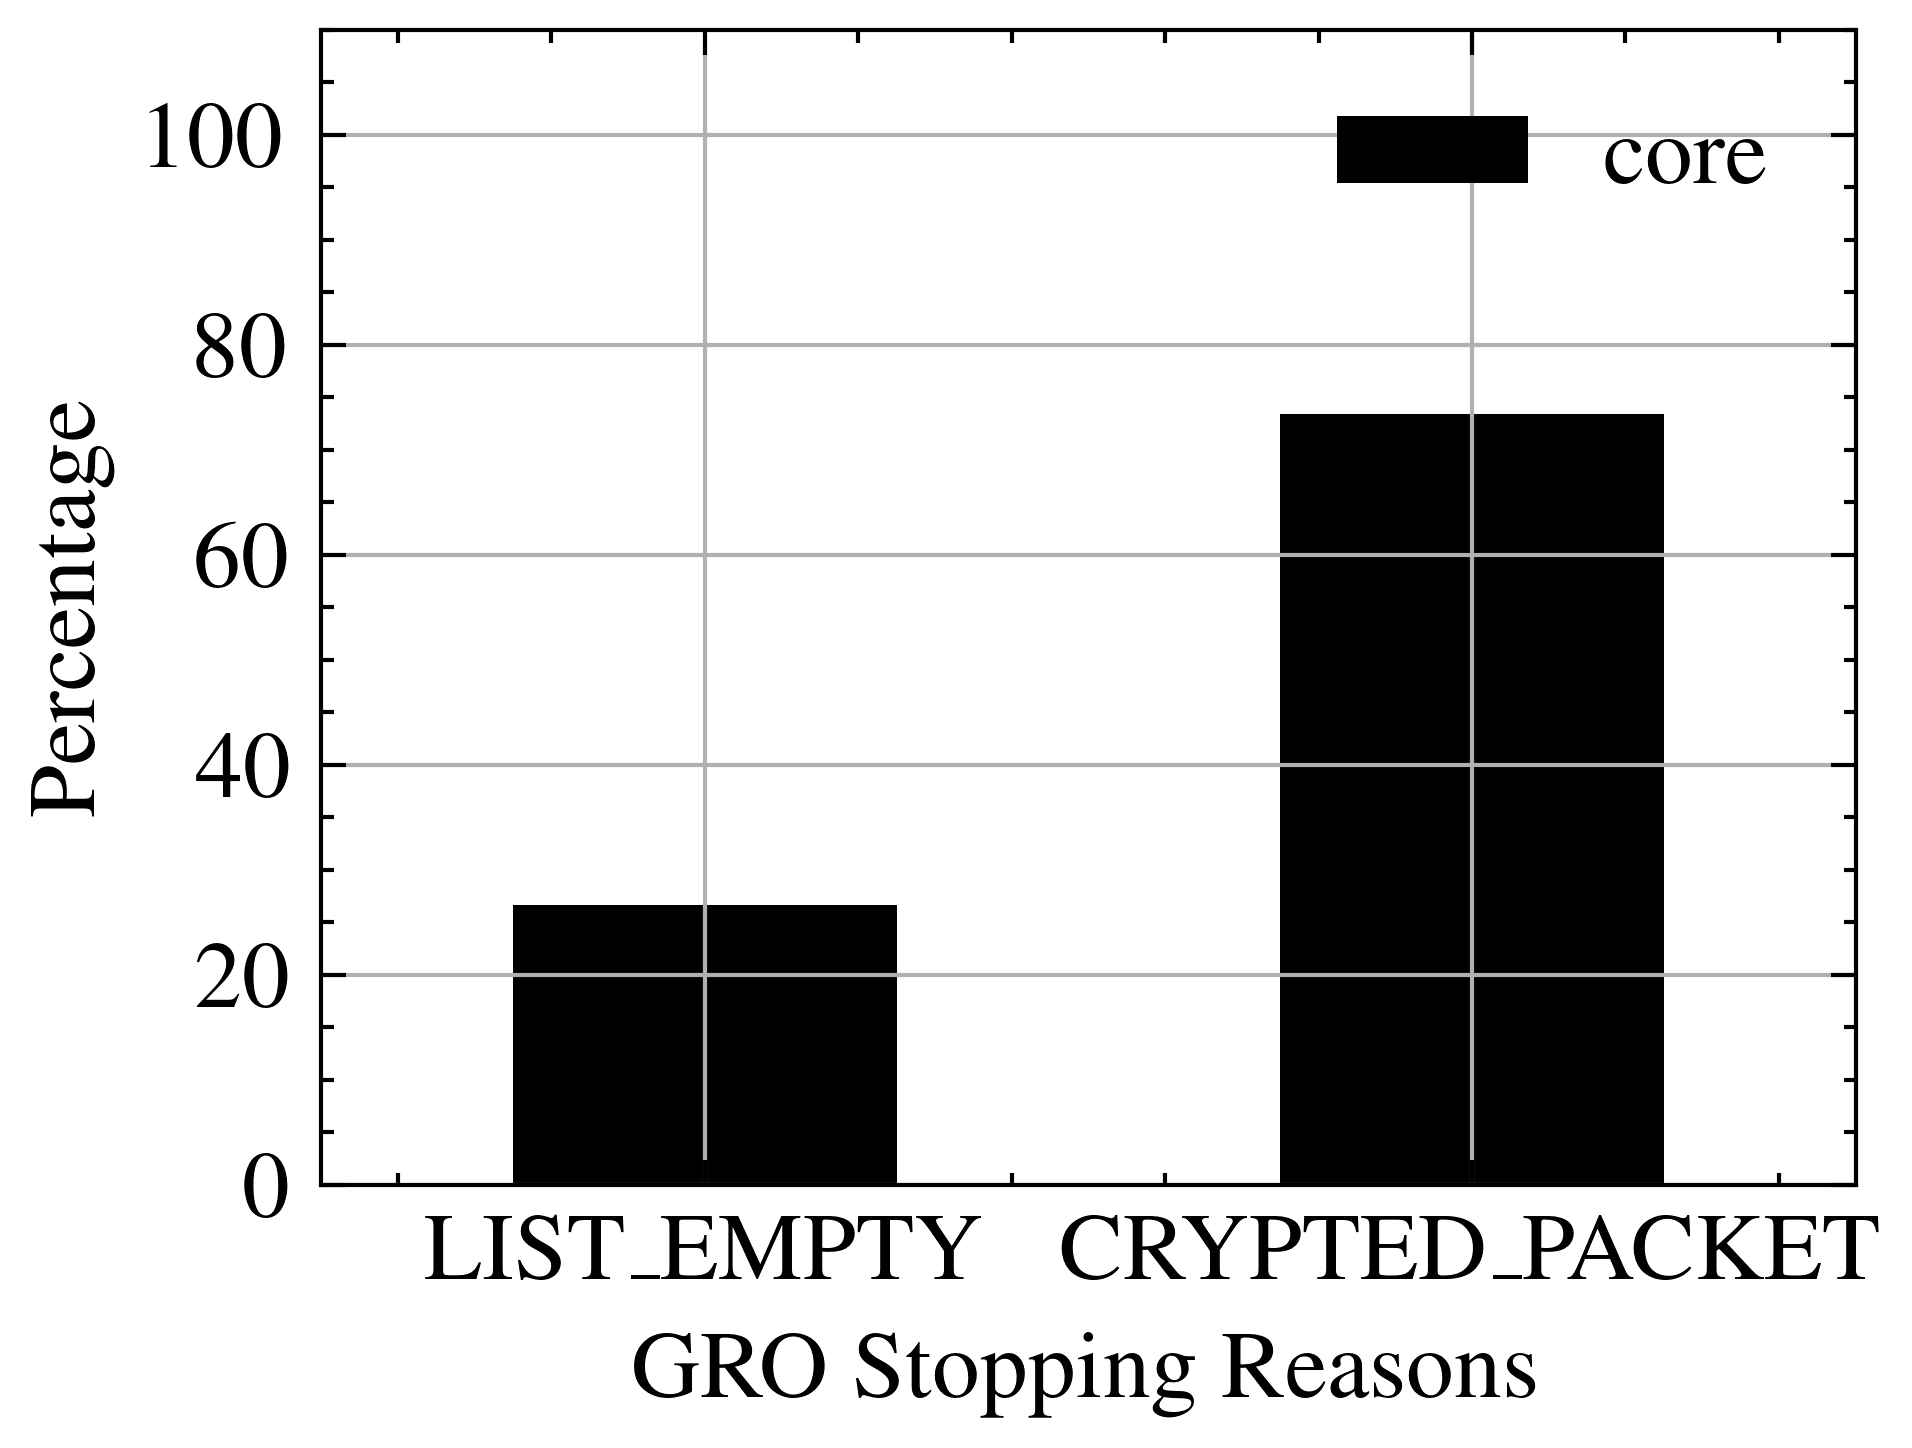

   stop  type  timestamp       core         RX STOP
0     1   0.0  26.632748  26.632748      LIST_EMPTY
1     2   0.0  73.367252  73.367252  CRYPTED_PACKET


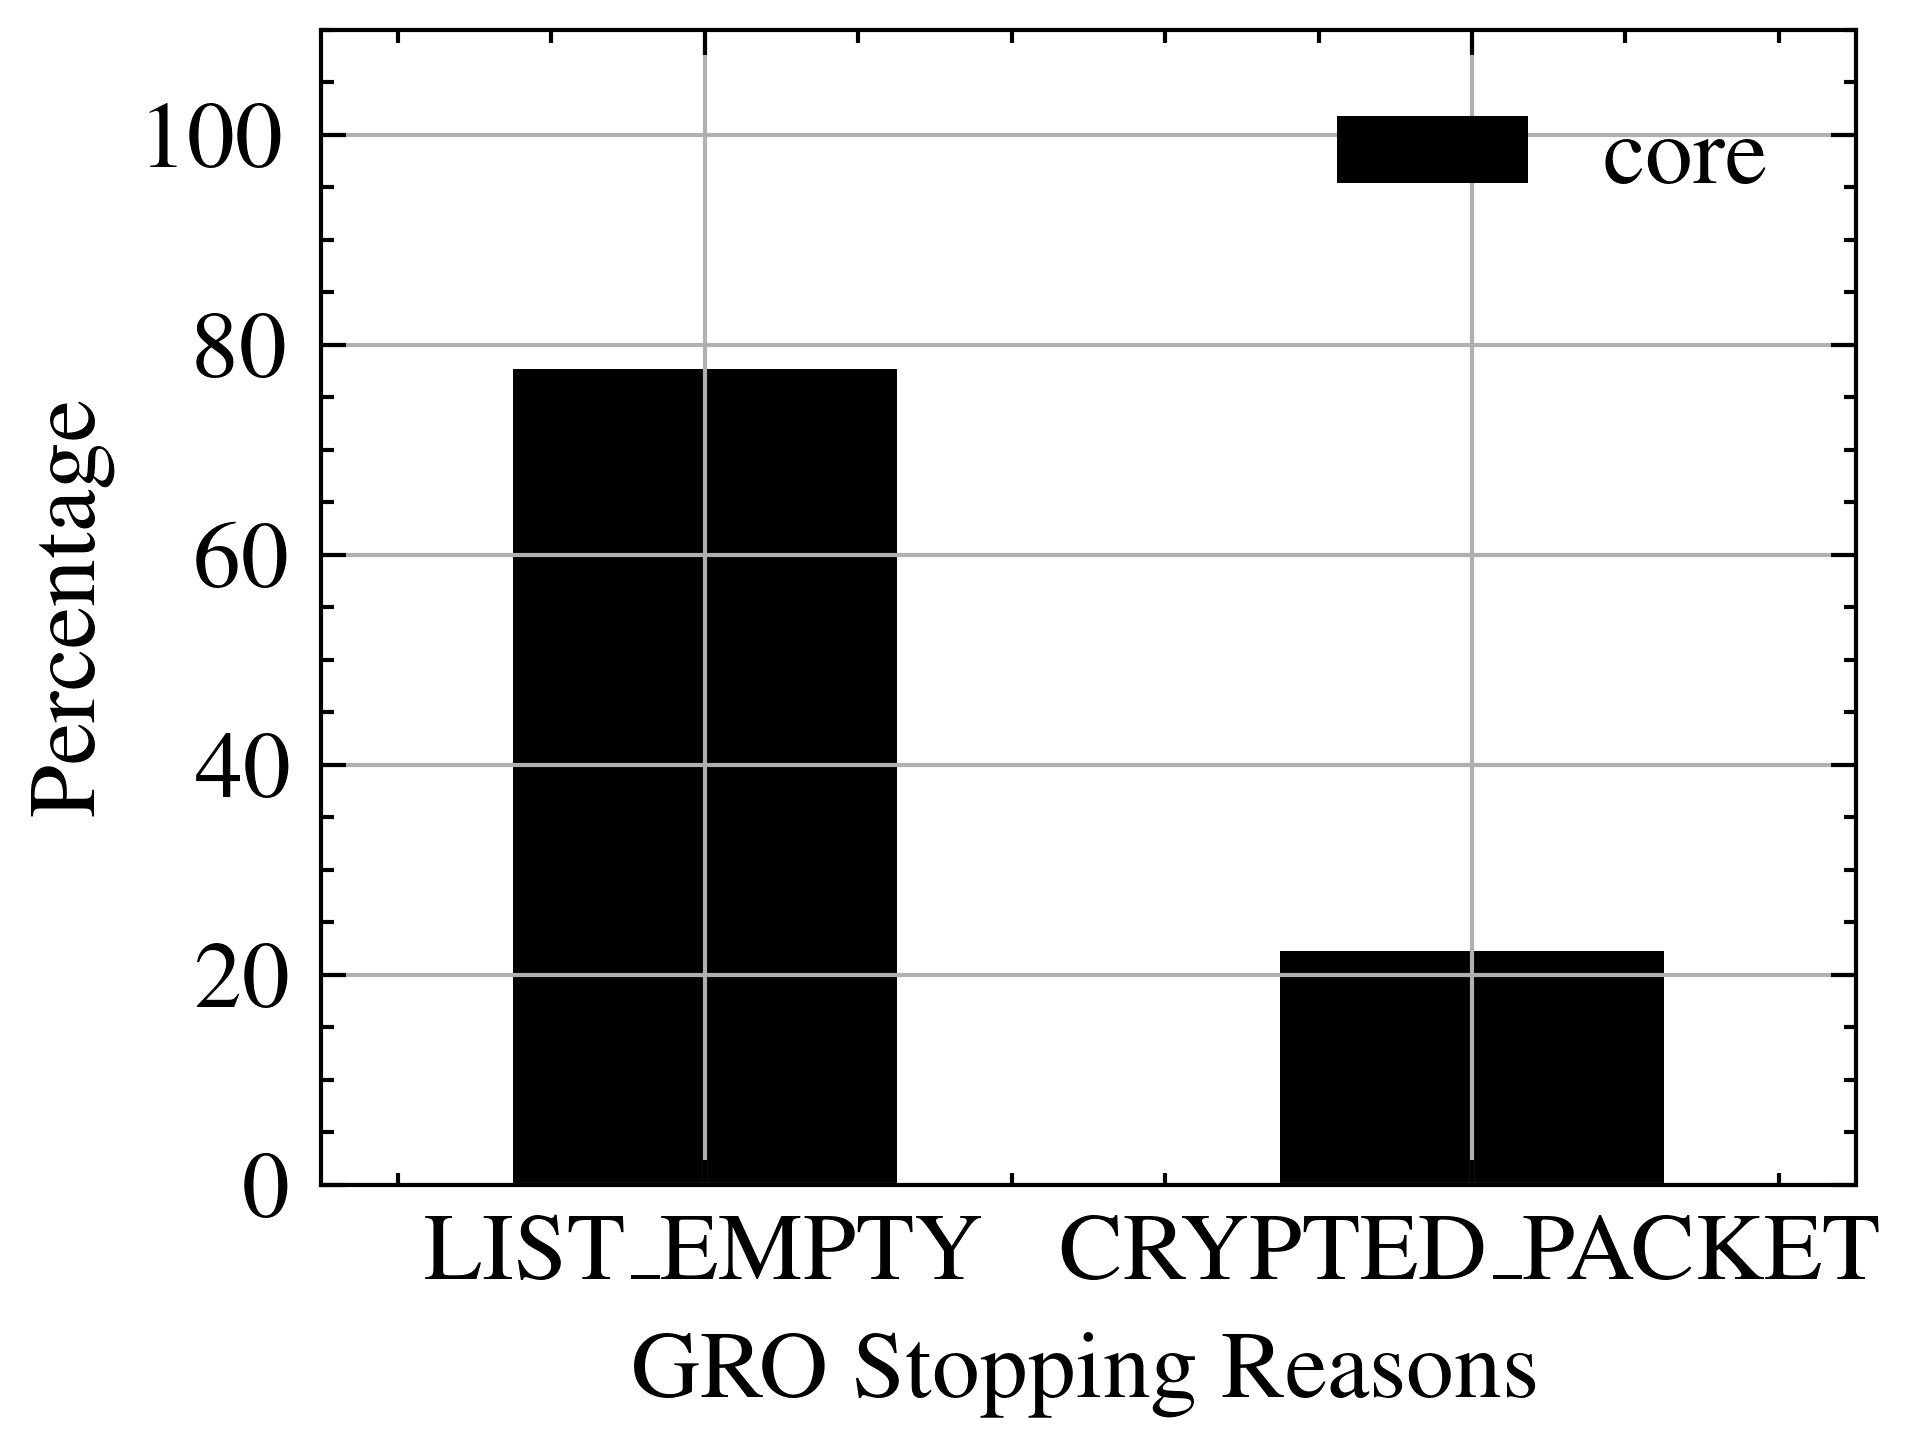

   stop  type  timestamp       core         RX STOP
0     1   0.0  77.716537  77.716537      LIST_EMPTY
1     2   0.0  22.283463  22.283463  CRYPTED_PACKET


In [67]:
plot_stops_up_down(variant="base")

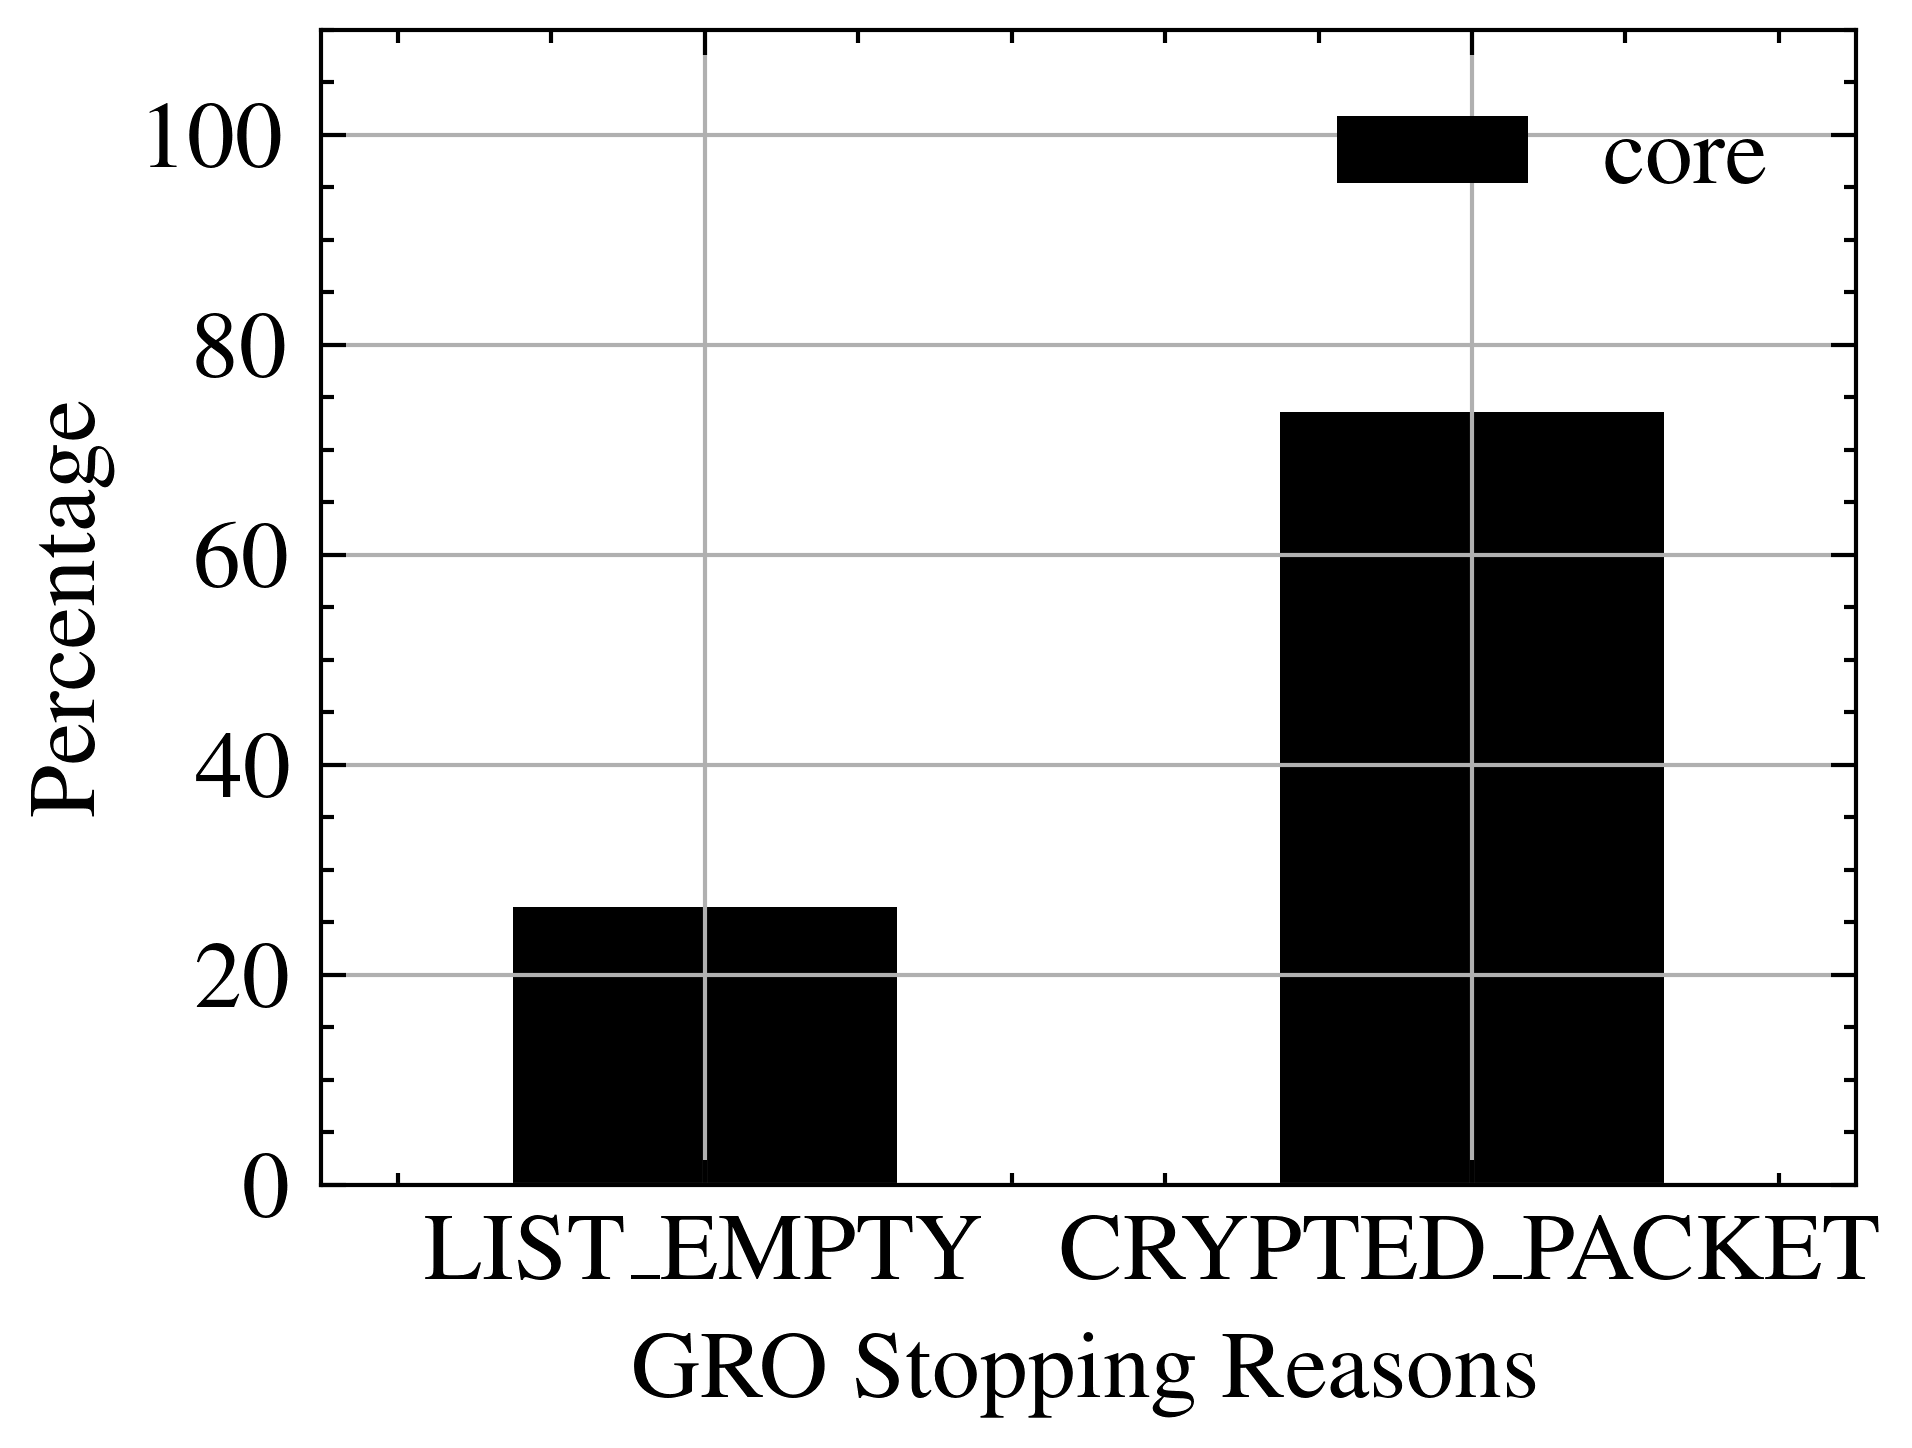

   stop  type  timestamp       core         RX STOP
0     1   0.0  26.435812  26.435812      LIST_EMPTY
1     2   0.0  73.564188  73.564188  CRYPTED_PACKET


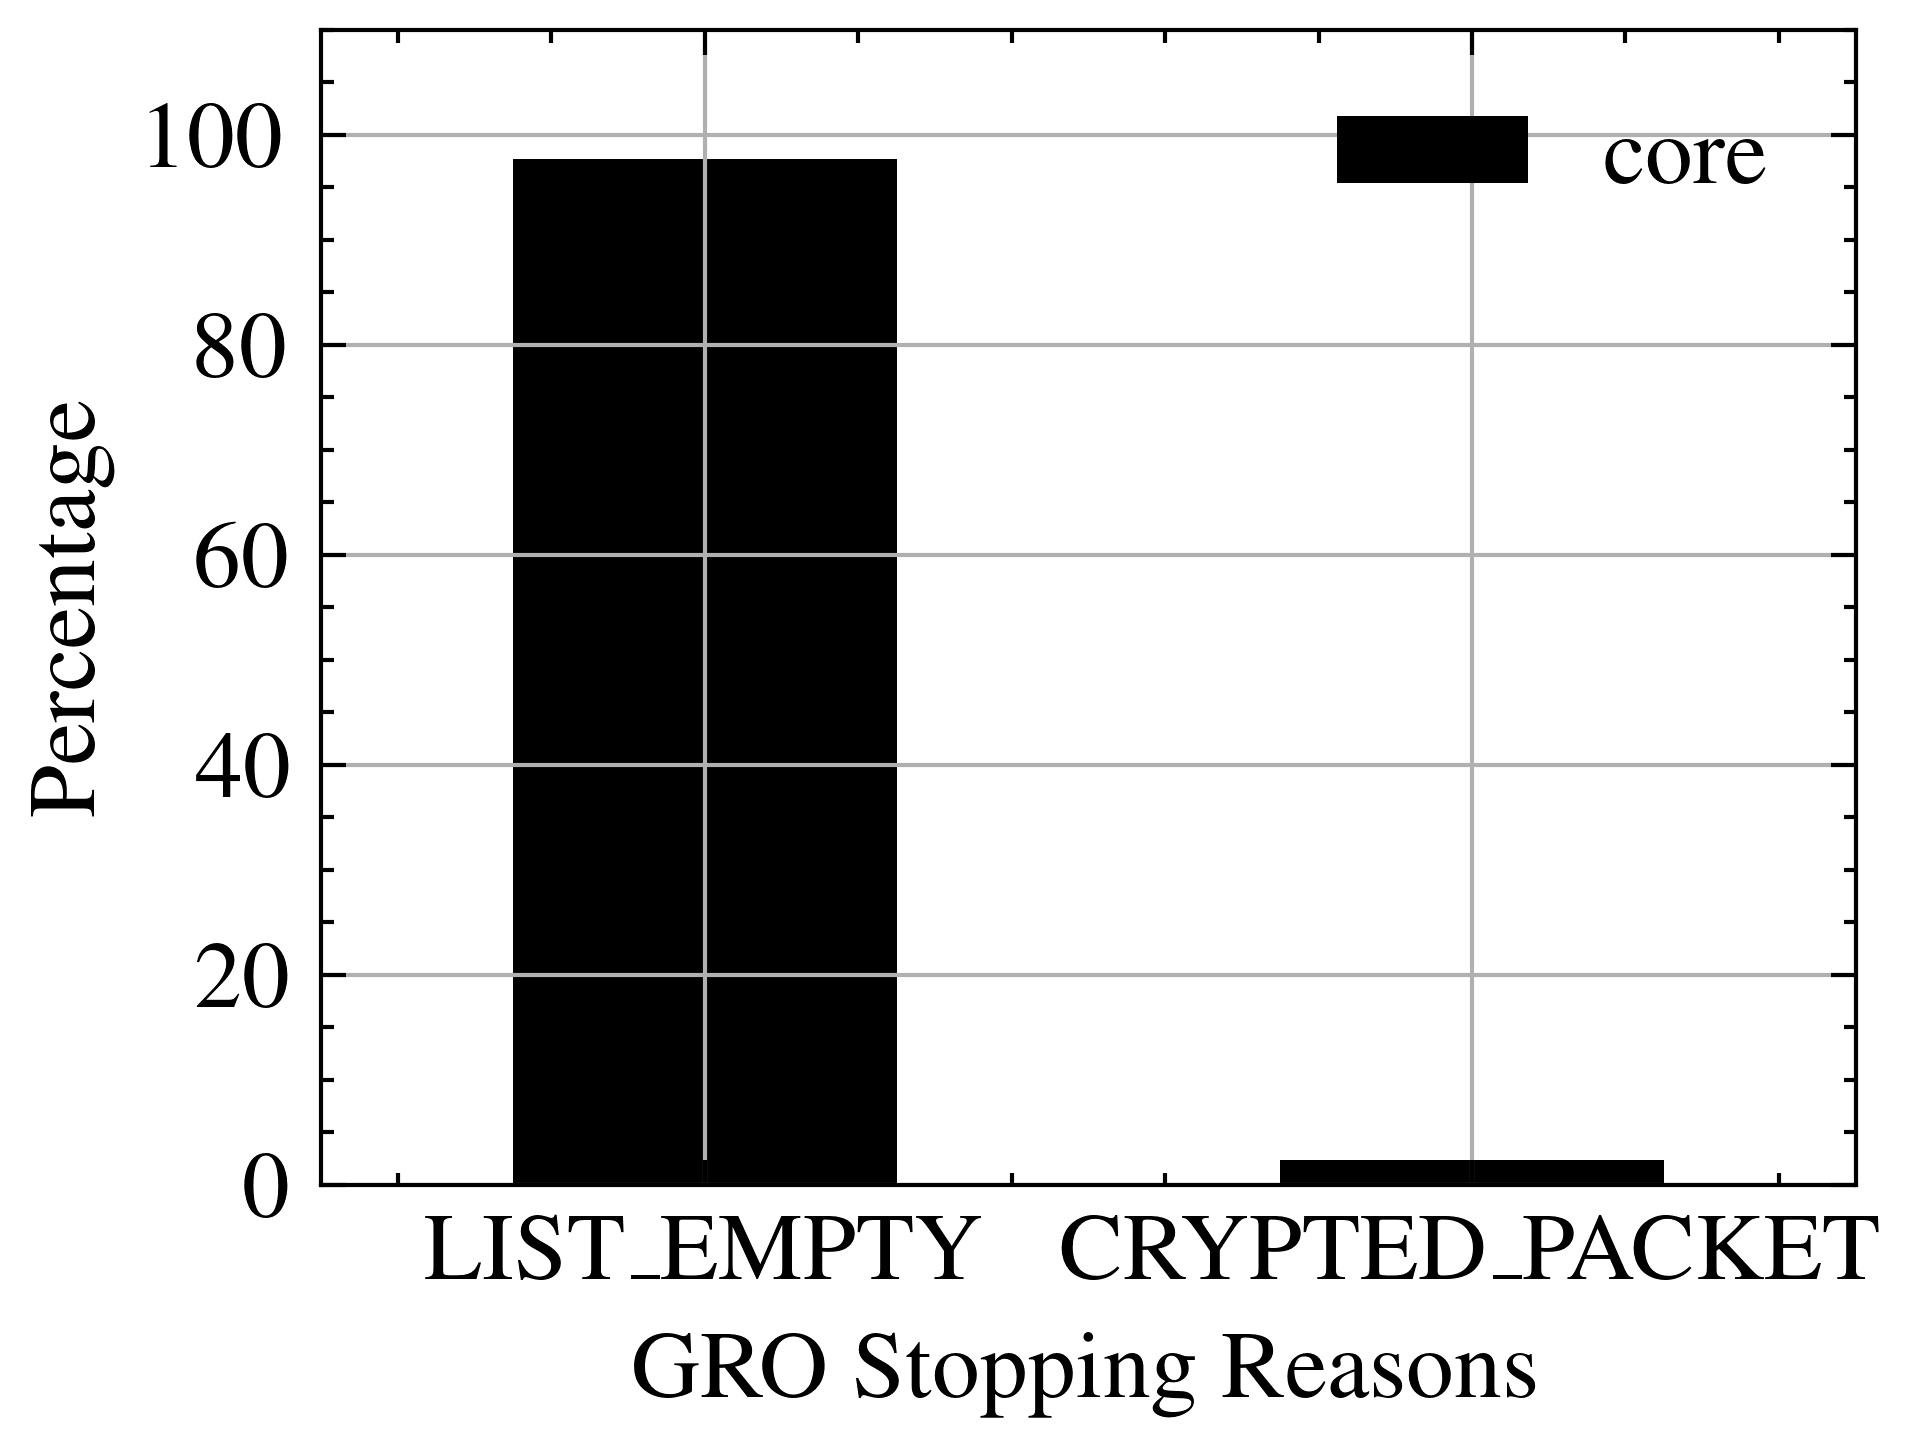

   stop  type  timestamp       core         RX STOP
0     1   0.0  97.673103  97.673103      LIST_EMPTY
1     2   0.0   2.326897   2.326897  CRYPTED_PACKET


In [70]:
plot_stops_up_down(variant="threaded")

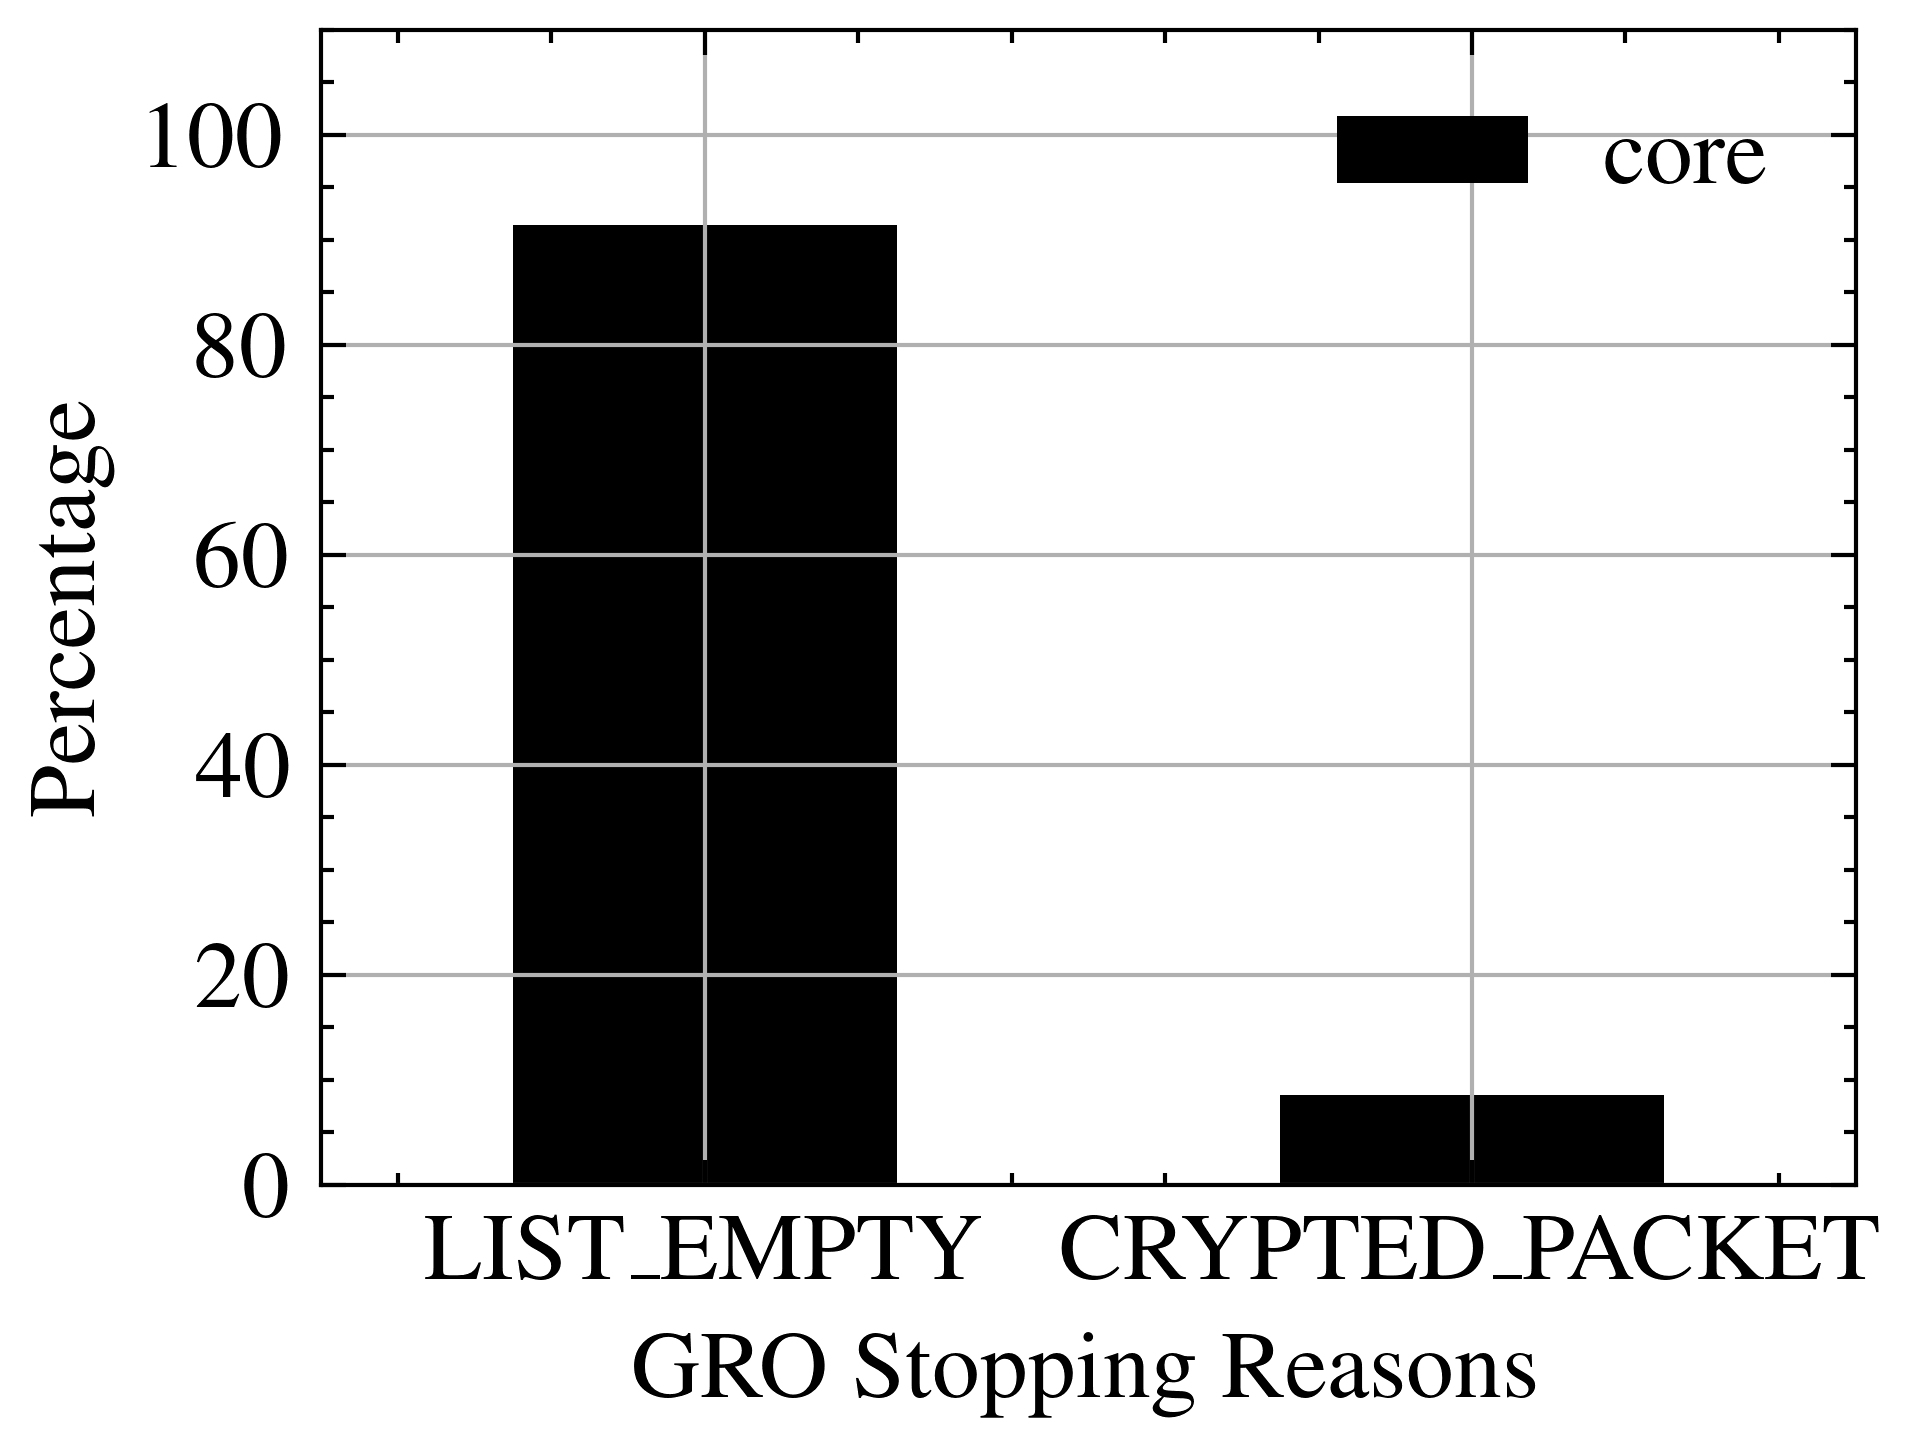

   stop  type  timestamp       core         RX STOP
0     1   0.0  91.422002  91.422002      LIST_EMPTY
1     2   0.0   8.577998   8.577998  CRYPTED_PACKET


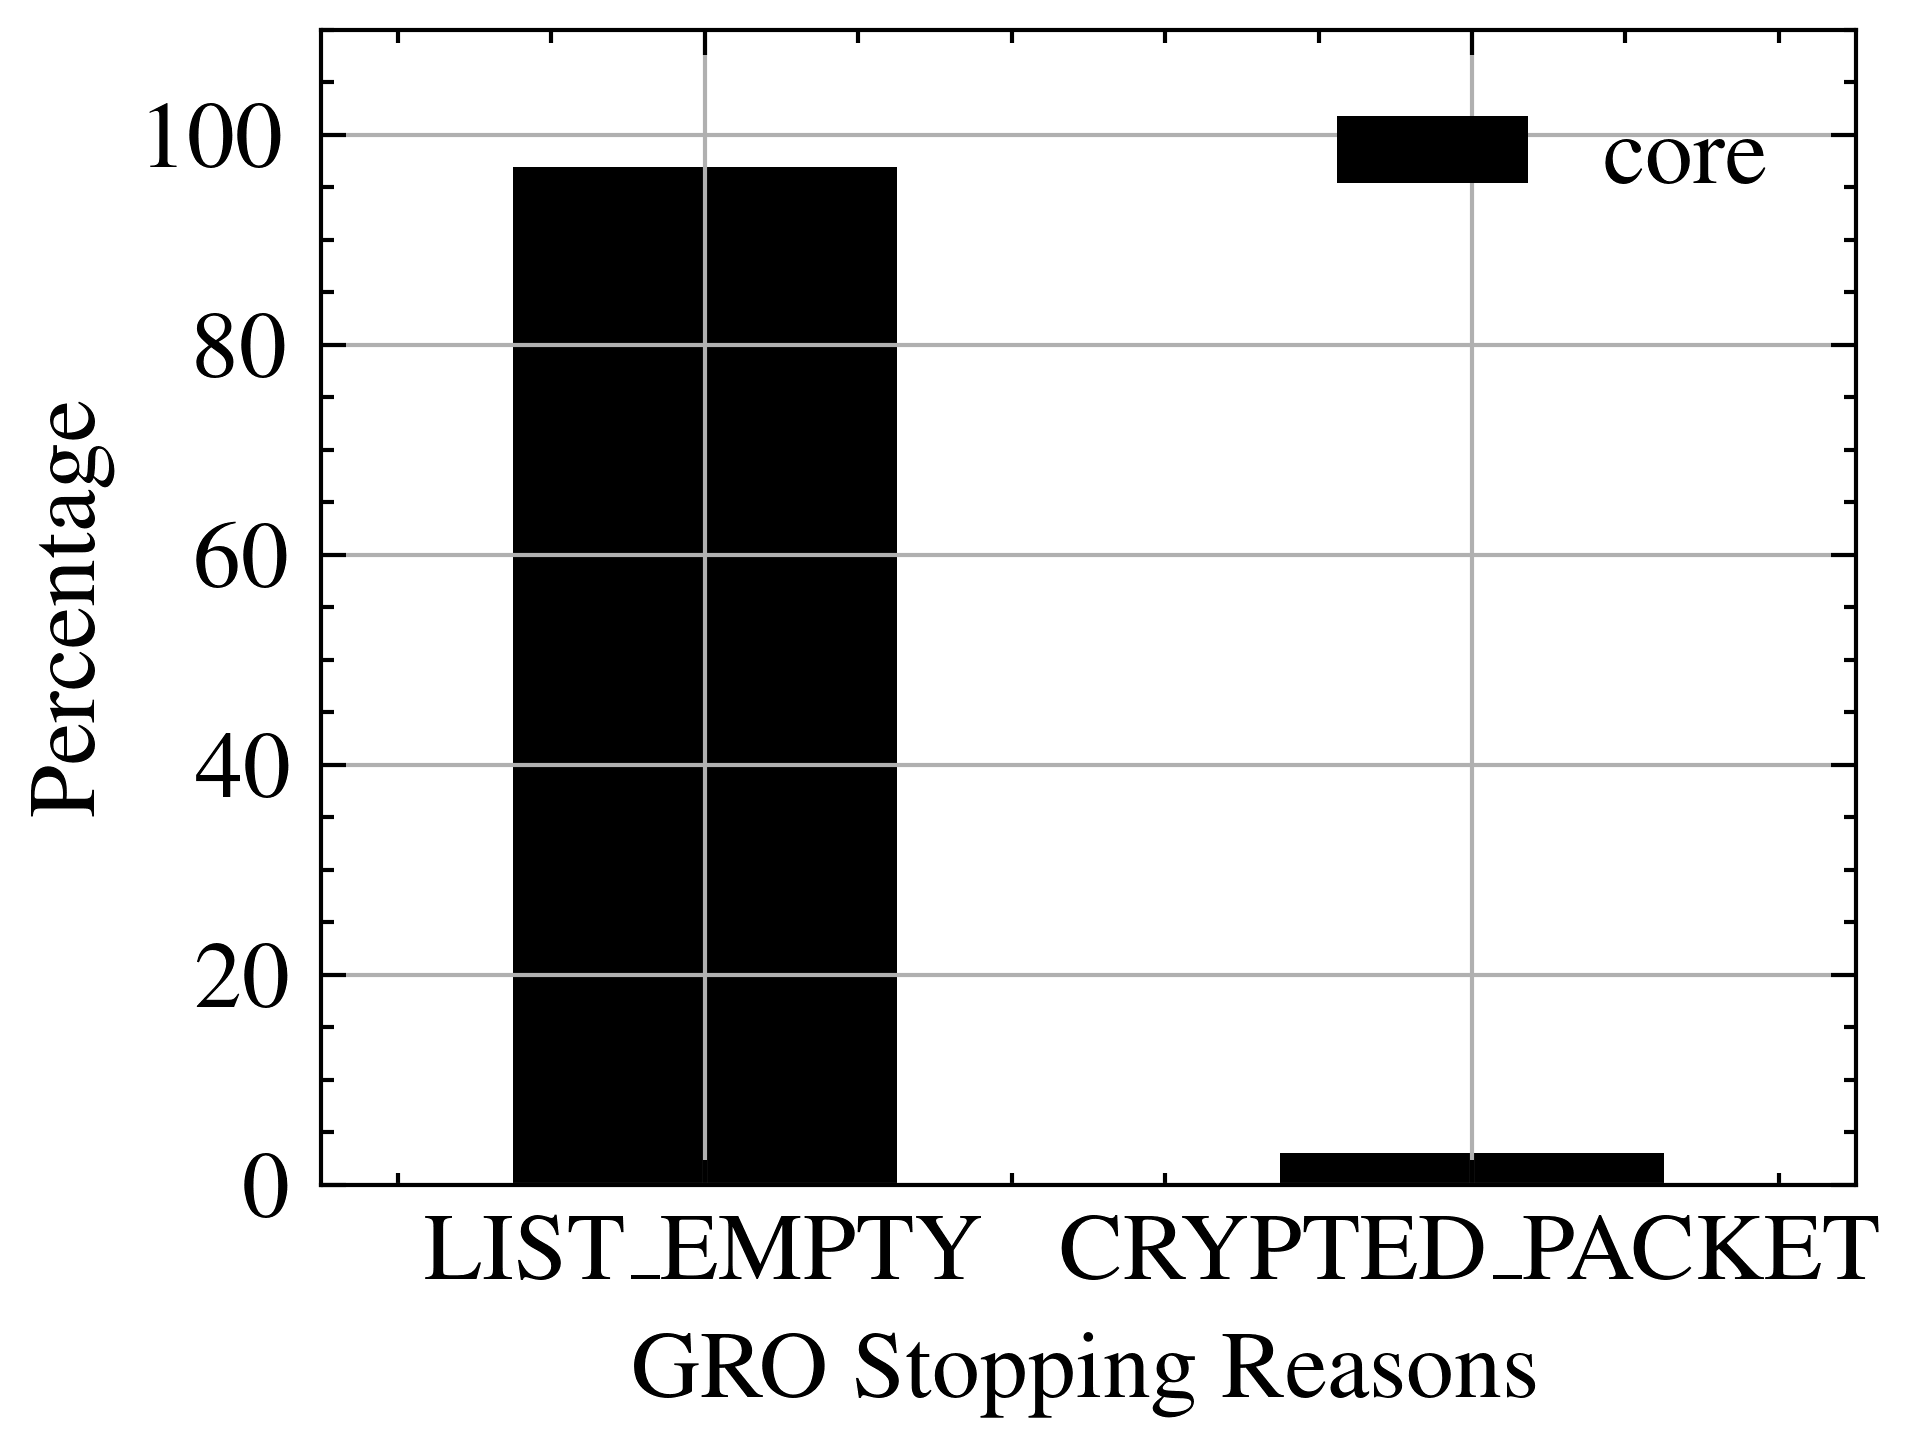

   stop  type  timestamp       core         RX STOP
0     1   0.0  96.948657  96.948657      LIST_EMPTY
1     2   0.0   3.051343   3.051343  CRYPTED_PACKET


In [69]:
plot_stops_up_down(variant="wq")

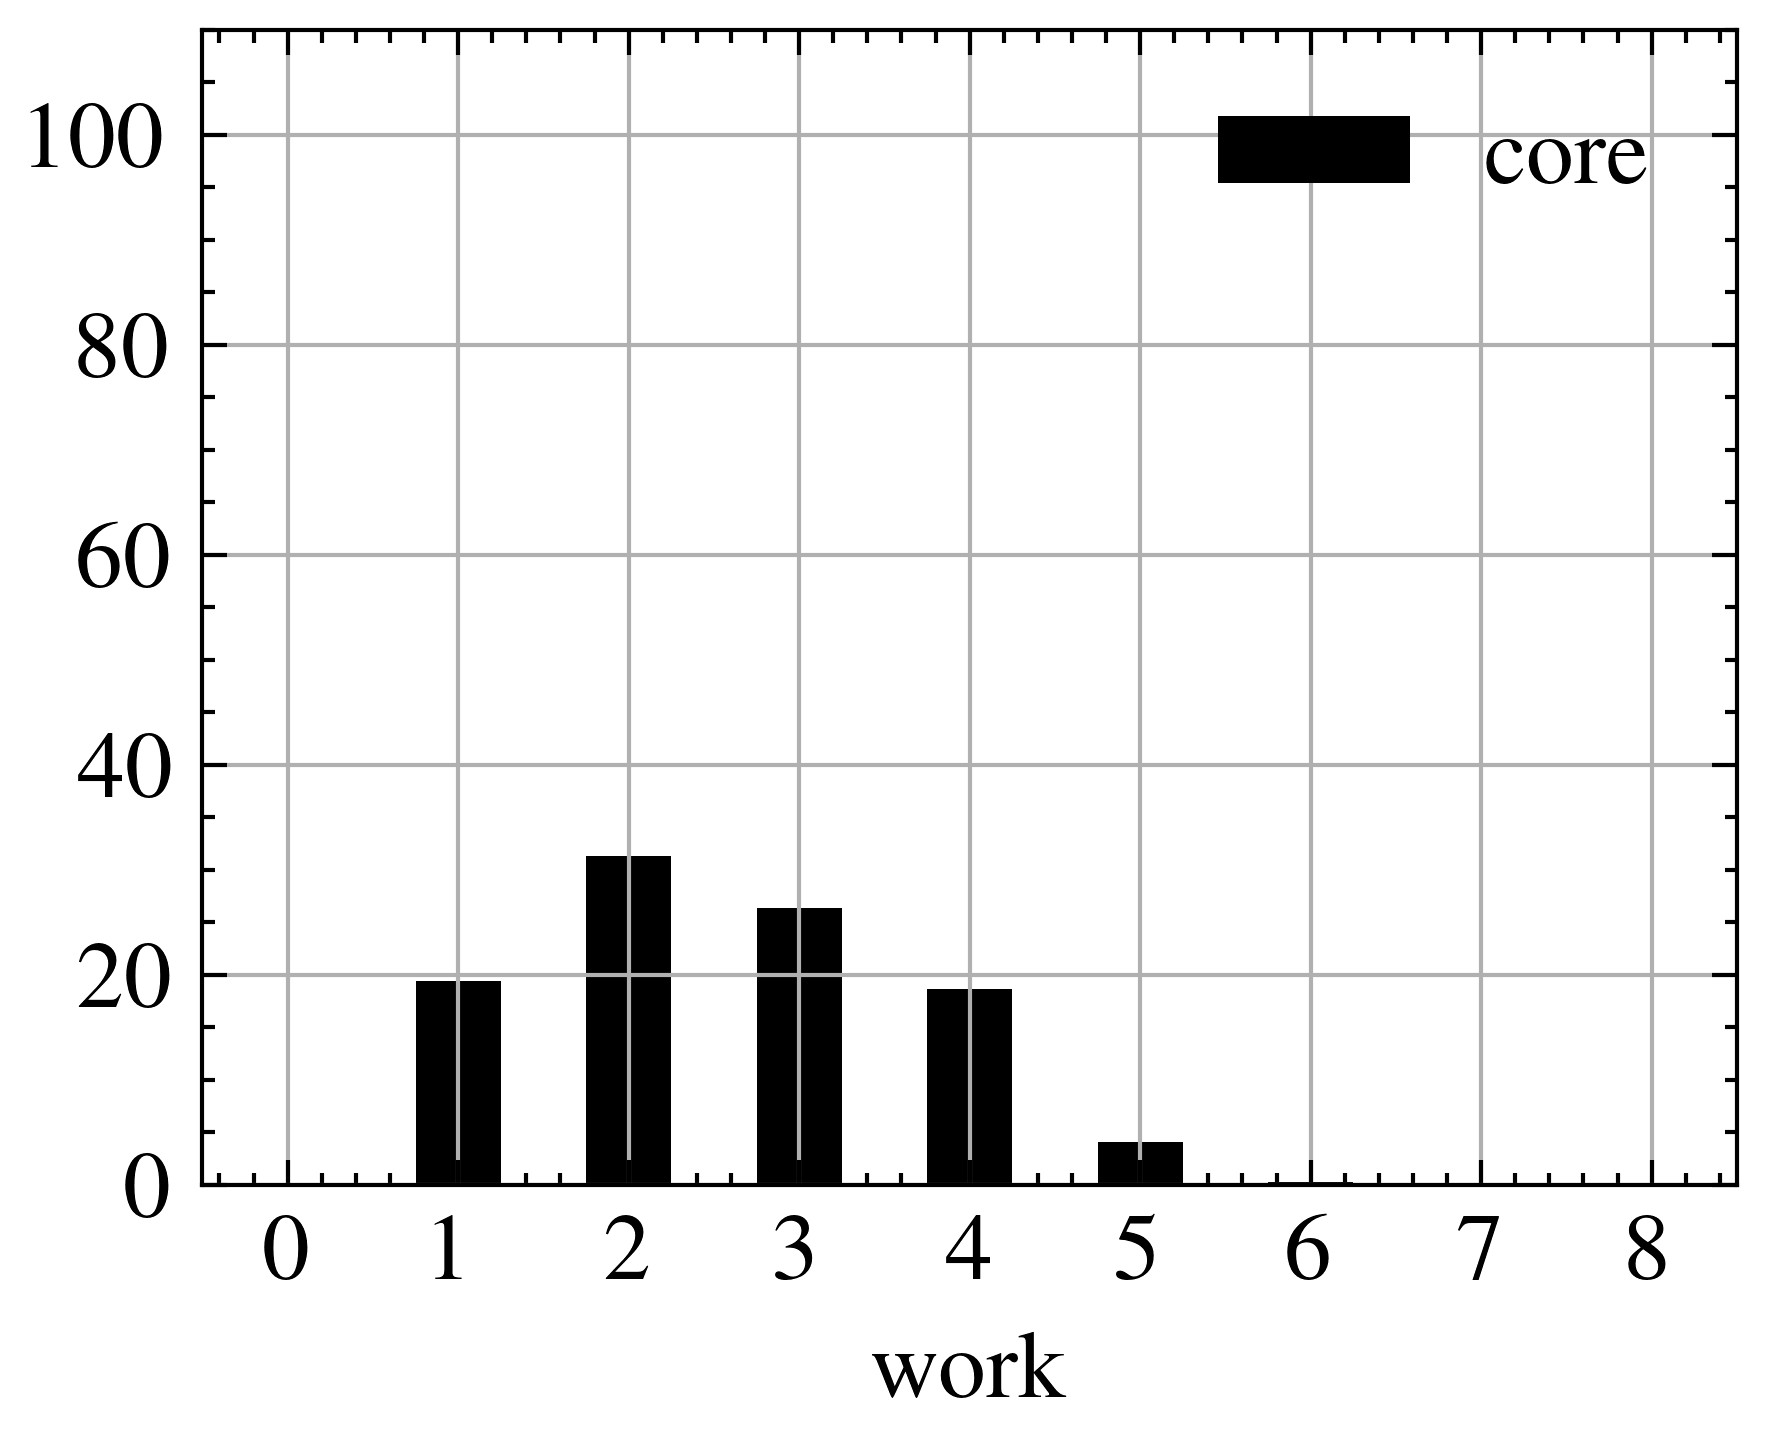

,work,type,thread_name,core,duration
0,0,0.0,0.003098,0.003098,0.003098
1,1,0.0,19.368369,19.368369,19.368369
2,2,0.0,31.319112,31.319112,31.319112
3,3,0.0,26.385502,26.385502,26.385502
4,4,0.0,18.655847,18.655847,18.655847
5,5,0.0,4.038999,4.038999,4.038999
6,6,0.0,0.210314,0.210314,0.210314
7,7,0.0,0.018071,0.018071,0.018071
8,8,0.0,0.000688,0.000688,0.000688


In [50]:
count = up_rx_worker.groupby('work').count()
total = up_rx_worker.count().work
count = count * 100 / total
count = count.reset_index()
# count['Stop reason'] = count.apply(lambda row: stop_types[row.stop], axis=1)
count.plot.bar(x='work', y='core', ylim=[0, 110], xlim=[0, 10])
plt.xticks(rotation=0)
plt.grid(True)
plt.show()
count

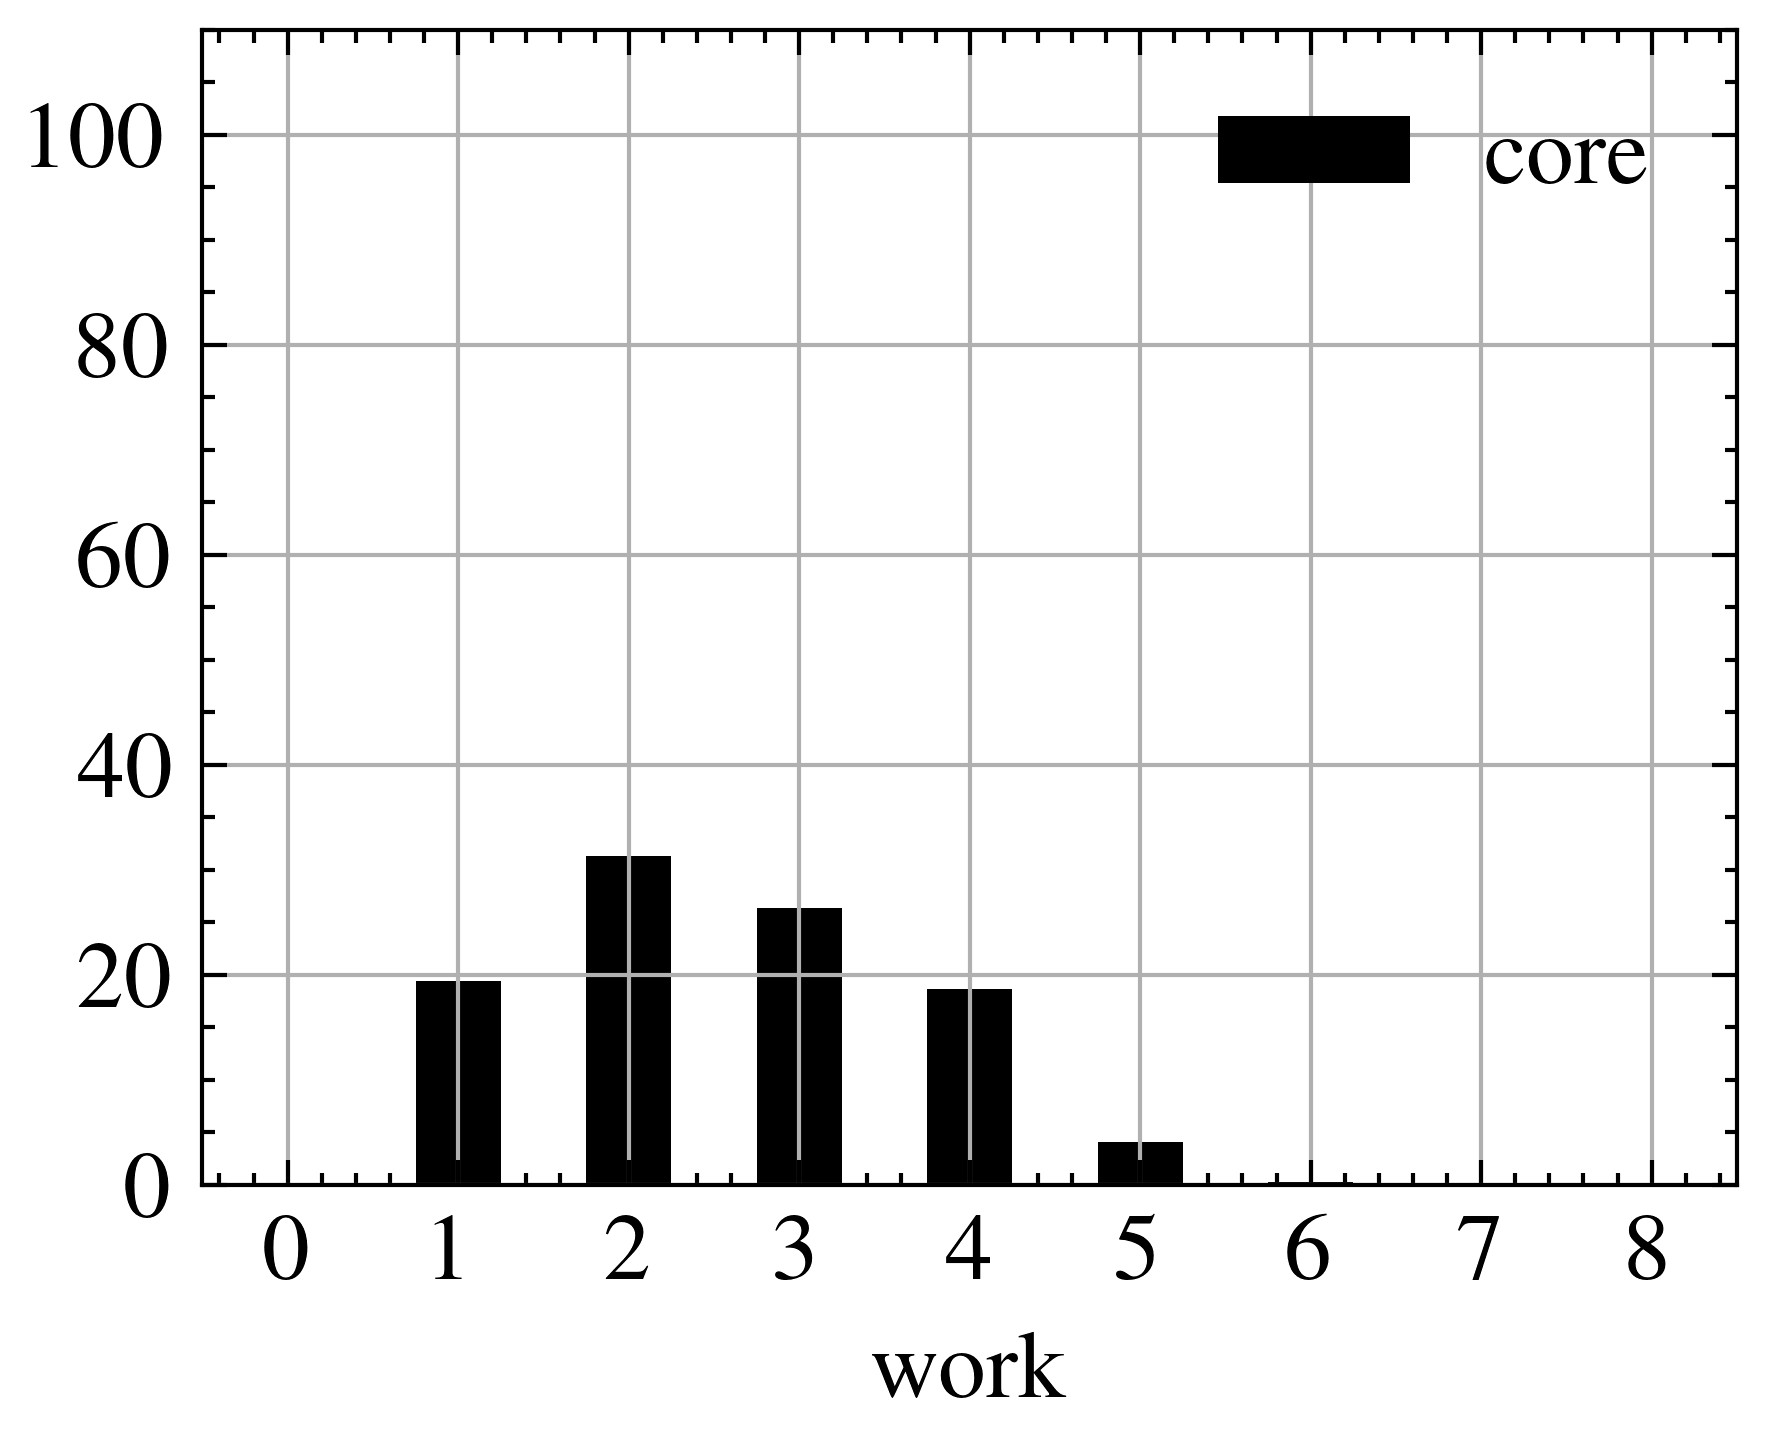

,work,type,thread_name,core,duration
0,0,0.0,0.003098,0.003098,0.003098
1,1,0.0,19.368369,19.368369,19.368369
2,2,0.0,31.319112,31.319112,31.319112
3,3,0.0,26.385502,26.385502,26.385502
4,4,0.0,18.655847,18.655847,18.655847
5,5,0.0,4.038999,4.038999,4.038999
6,6,0.0,0.210314,0.210314,0.210314
7,7,0.0,0.018071,0.018071,0.018071
8,8,0.0,0.000688,0.000688,0.000688


In [51]:
count = up_rx_worker.groupby('work').count()
total = up_rx_worker.count().work
count = count * 100 / total
count = count.reset_index()
# count['Stop reason'] = count.apply(lambda row: stop_types[row.stop], axis=1)
count.plot.bar(x='work', y='core', ylim=[0, 110], xlim=[0, 10])
plt.xticks(rotation=0)
plt.grid(True)
plt.show()
count

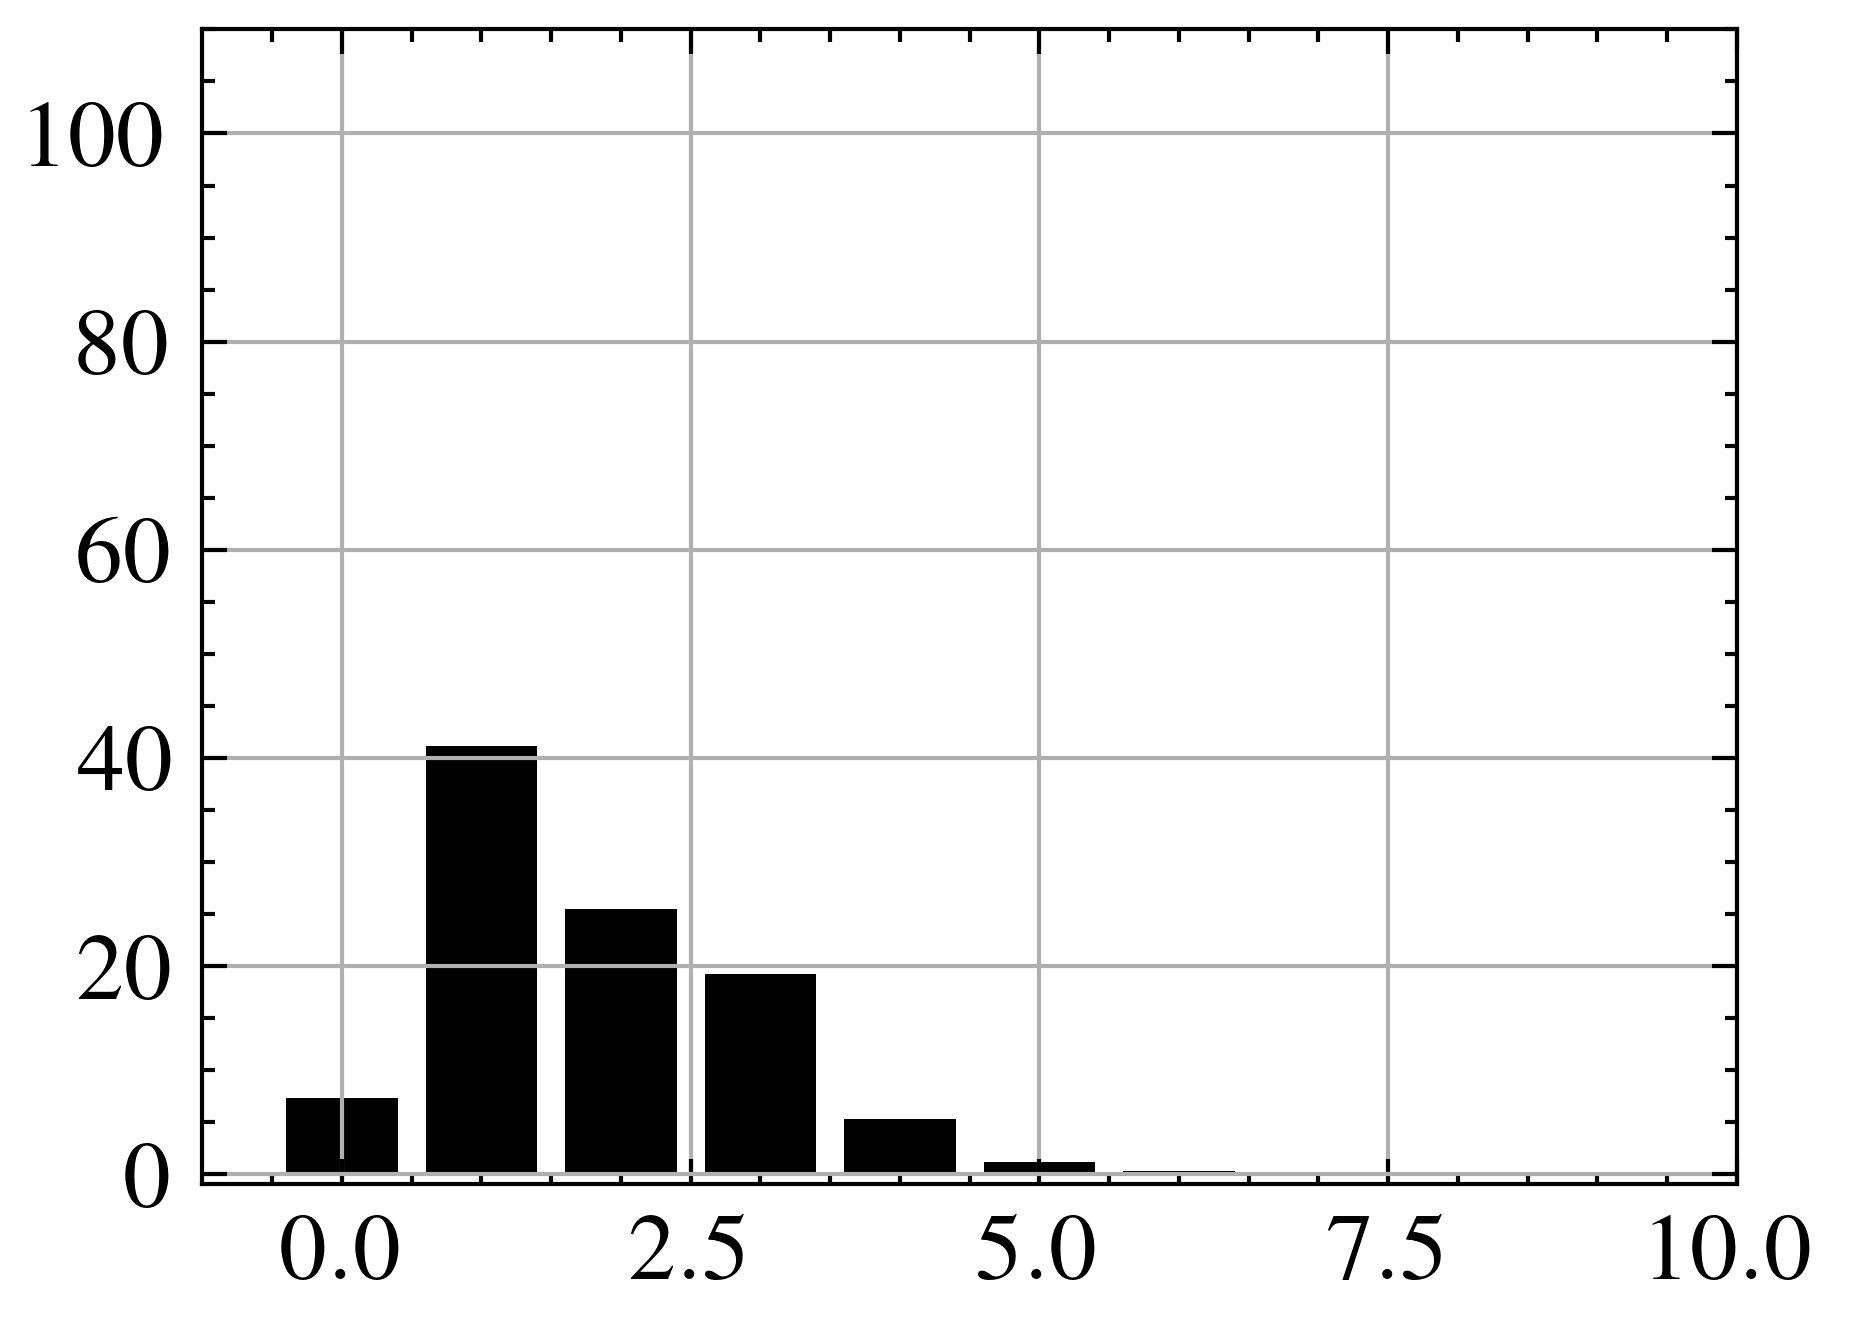

,work,type,thread_name,core,duration
0,0,0.0,7.272161,7.272161,7.272161
1,1,0.0,41.169024,41.169024,41.169024
2,2,0.0,25.470848,25.470848,25.470848
3,3,0.0,19.263016,19.263016,19.263016
4,4,0.0,5.249499,5.249499,5.249499
5,5,0.0,1.184409,1.184409,1.184409
6,6,0.0,0.271292,0.271292,0.271292
7,7,0.0,0.071735,0.071735,0.071735
8,8,0.0,0.019602,0.019602,0.019602
9,9,0.0,0.007083,0.007083,0.007083


In [52]:
count = down_tx_worker.groupby('work').count()
total = down_tx_worker.count().work
count = count * 100 / total
count = count.reset_index()
# count['Stop reason'] = count.apply(lambda row: stop_types[row.stop], axis=1)
# count.plot.bar(x='work', y='core', ylim=[0, 110])
# plt.figure(figsize=(15, 5))
plt.bar(count.work, count.core)
plt.xlim([-1, 10])
plt.ylim([-1, 110])
plt.grid(True)
plt.xticks(rotation=0)
plt.show()
count.head(10)

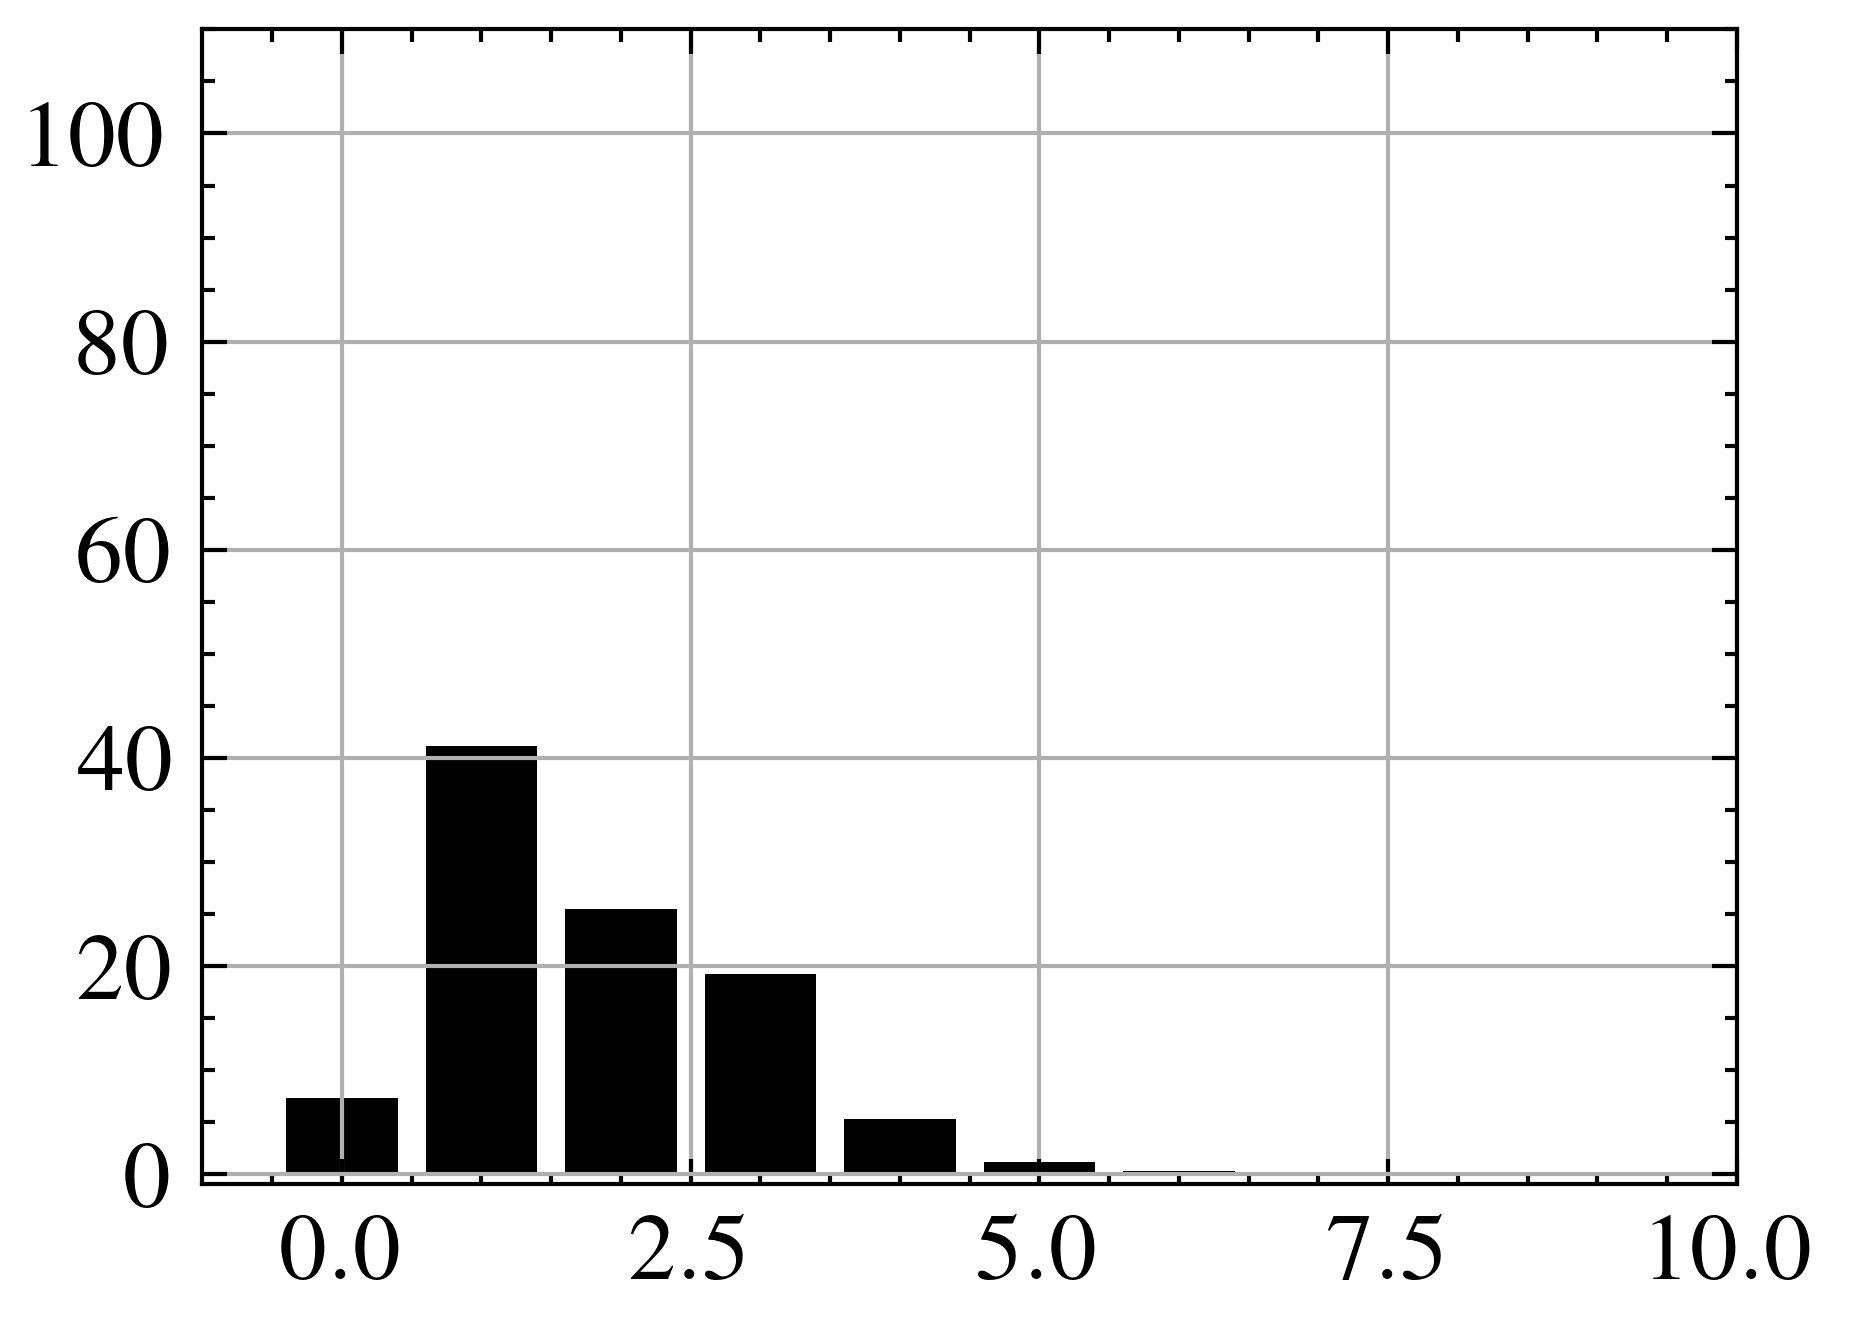

,work,type,thread_name,core,duration
0,0,0.0,7.272161,7.272161,7.272161
1,1,0.0,41.169024,41.169024,41.169024
2,2,0.0,25.470848,25.470848,25.470848
3,3,0.0,19.263016,19.263016,19.263016
4,4,0.0,5.249499,5.249499,5.249499
5,5,0.0,1.184409,1.184409,1.184409
6,6,0.0,0.271292,0.271292,0.271292
7,7,0.0,0.071735,0.071735,0.071735
8,8,0.0,0.019602,0.019602,0.019602
9,9,0.0,0.007083,0.007083,0.007083


In [53]:
count = down_tx_worker.groupby('work').count()
total = down_tx_worker.count().work
count = count * 100 / total
count = count.reset_index()
# count['Stop reason'] = count.apply(lambda row: stop_types[row.stop], axis=1)
# count.plot.bar(x='work', y='core', ylim=[0, 110])
# plt.figure(figsize=(15, 5))
plt.bar(count.work, count.core)
plt.xlim([-1, 10])
plt.ylim([-1, 110])
plt.grid(True)
plt.xticks(rotation=0)
plt.show()
count.head(10)

<AxesSubplot: >

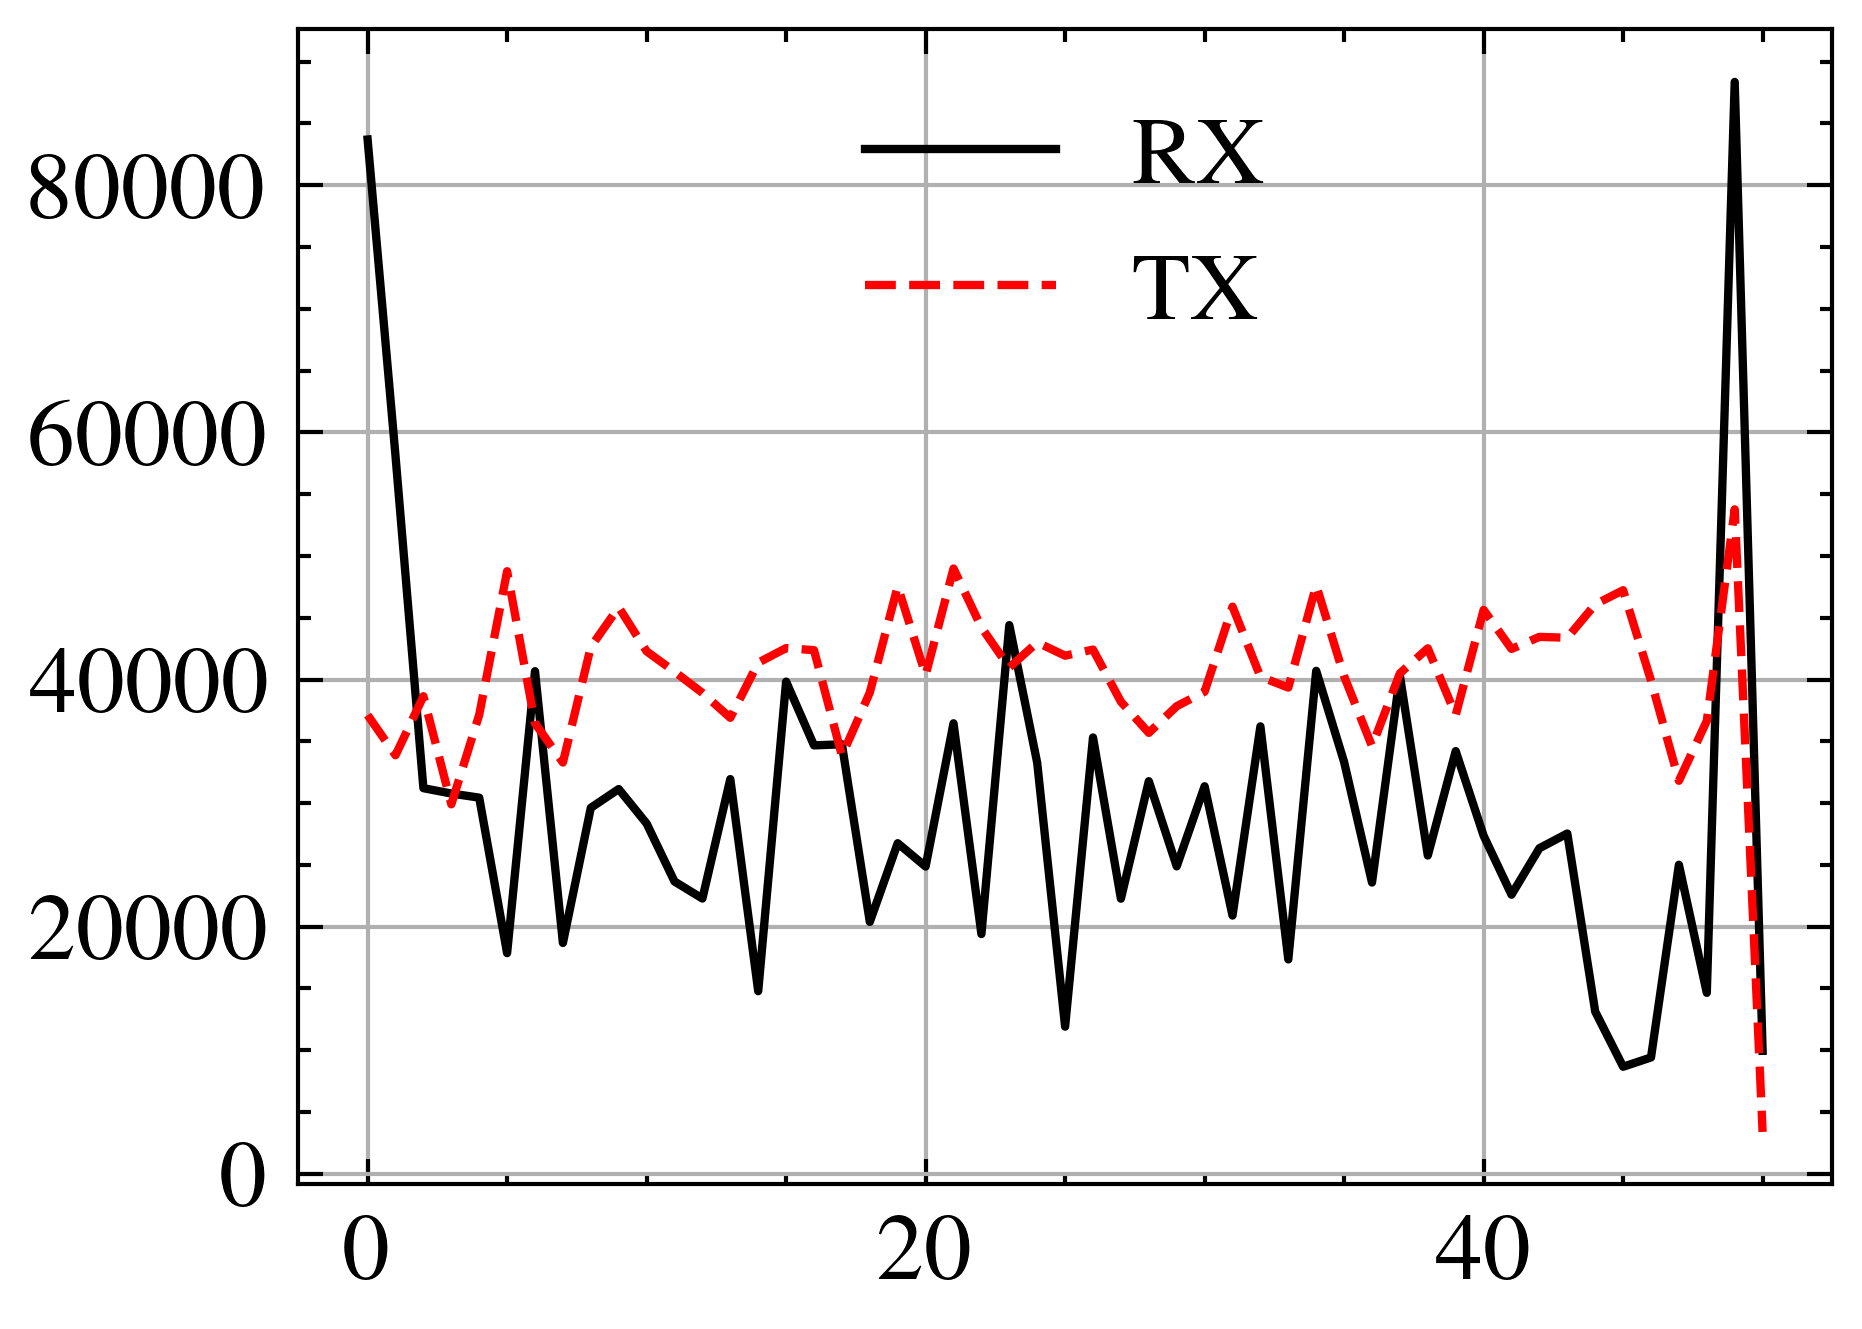

In [54]:
sampling_rate = '100L'

df = up_decrypt_packet
start = df.timestamp.iloc[0]
df.timestamp -= start

df['datetime'] = pd.to_datetime(df.timestamp, unit='s')
df = df.set_index('datetime')

sampled = df.resample(sampling_rate).count()
ax = sampled.reset_index(drop=True).plot(y='duration', label='RX')

df = down_encrypt_packet
start = df.timestamp.iloc[0]
df.timestamp -= start

df['datetime'] = pd.to_datetime(df.timestamp, unit='s')
df = df.set_index('datetime')

sampled = df.resample(sampling_rate).count()
sampled.reset_index(drop=True).plot(ax=ax, y='duration', label='TX', grid=True)

<AxesSubplot: >

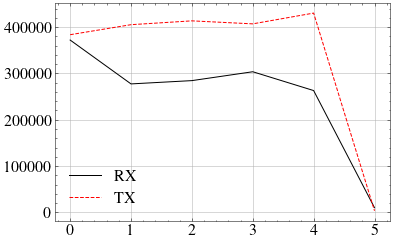

In [282]:
sampling_rate = '1000L'

df = up_decrypt_packet
start = df.timestamp.iloc[0]
df.timestamp -= start

df['datetime'] = pd.to_datetime(df.timestamp, unit='s')
df = df.set_index('datetime')

sampled = df.resample(sampling_rate).count()
ax = sampled.reset_index(drop=True).plot(y='duration', label='RX')

df = down_encrypt_packet
start = df.timestamp.iloc[0]
df.timestamp -= start

df['datetime'] = pd.to_datetime(df.timestamp, unit='s')
df = df.set_index('datetime')

sampled = df.resample(sampling_rate).count()
sampled.reset_index(drop=True).plot(ax=ax, y='duration', label='TX', grid=True)

<AxesSubplot: >

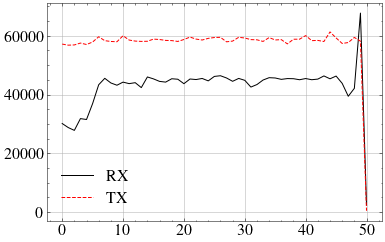

In [237]:
sampling_rate = '100L'

df = up_rx_packet
start = df.timestamp.iloc[0]
df.timestamp -= start

df['datetime'] = pd.to_datetime(df.timestamp, unit='s')
df = df.set_index('datetime')

sampled = df.resample(sampling_rate).count()
ax = sampled.reset_index(drop=True).plot(y='duration', label='RX')

df = down_tx_packet
start = df.timestamp.iloc[0]
df.timestamp -= start

df['datetime'] = pd.to_datetime(df.timestamp, unit='s')
df = df.set_index('datetime')

sampled = df.resample(sampling_rate).count()
sampled.reset_index(drop=True).plot(ax=ax, y='duration', label='TX', grid=True)

<AxesSubplot: >

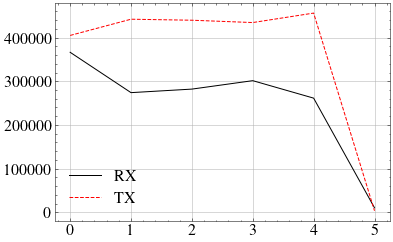

In [283]:
sampling_rate = '1000L'

df = up_rx_packet
start = df.timestamp.iloc[0]
df.timestamp -= start

df['datetime'] = pd.to_datetime(df.timestamp, unit='s')
df = df.set_index('datetime')

sampled = df.resample(sampling_rate).count()
ax = sampled.reset_index(drop=True).plot(y='duration', label='RX')

df = down_tx_packet
start = df.timestamp.iloc[0]
df.timestamp -= start

df['datetime'] = pd.to_datetime(df.timestamp, unit='s')
df = df.set_index('datetime')

sampled = df.resample(sampling_rate).count()
sampled.reset_index(drop=True).plot(ax=ax, y='duration', label='TX', grid=True)

In [238]:
up_rx_packet.duration.describe()

count    2.176876e+06
mean     7.467650e+02
std      2.254425e+02
min      6.500000e+01
25%      6.430000e+02
50%      7.410000e+02
75%      8.210000e+02
max      1.058500e+04
Name: duration, dtype: float64

In [284]:
up_rx_packet.duration.describe()

count    1.495429e+06
mean     8.200431e+02
std      7.671465e+02
min      2.560000e+02
25%      5.660000e+02
50%      6.550000e+02
75%      8.190000e+02
max      1.631400e+04
Name: duration, dtype: float64

In [239]:
down_tx_packet.duration.describe()

count    2.925872e+06
mean     1.355816e+04
std      4.174026e+05
min      9.200000e+01
25%      2.300000e+03
50%      3.321000e+03
75%      6.702000e+03
max      1.943444e+08
Name: duration, dtype: float64

In [285]:
down_tx_packet.duration.describe()

count    2.181051e+06
mean     1.655649e+04
std      5.022265e+05
min      8.800000e+01
25%      2.313000e+03
50%      3.480000e+03
75%      7.257000e+03
max      1.344010e+08
Name: duration, dtype: float64